In [1]:
from os import getcwd,listdir,chdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch as mpatch
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
import seaborn as sns
import matplotlib.cm as cm

from scipy.stats import zscore,pearsonr,ttest_ind,ttest_rel
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from scipy.spatial import distance
from statsmodels.formula.api import ols
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LassoCV,LogisticRegressionCV
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from skbio.diversity import alpha,beta_diversity
from skbio.stats import composition
from sklearn.ensemble import RandomForestClassifier
from umap import UMAP

from tqdm.notebook import tqdm as progbar

sns.set(context='talk',style='ticks',font_scale=1,rc ={'axes.spines.right': False,'axes.spines.top': False,'pdf.fonttype':42,'ps.fonttype':42},palette='colorblind')

## Growth rate assocations

In [2]:
growth_rates = pd.read_pickle('/Users/mengya/SDU/GSMM/mt_project/results_new/final_invade0.1_growth_rates_tradeoff0.8_pfba-new.pkl').reset_index()
growth_rates

,compartments,growth_rate,abundance,sample,condition,tradeoff
0,Acinetobacter_guillouiae,0.002653,0.000058,H19,0.1cal-invaded,0.8
1,Acinetobacter_johnsonii,0.005450,0.000067,H19,0.1cal-invaded,0.8
2,Aspergillus_oryzae,0.011974,0.000263,H19,0.1cal-invaded,0.8
3,Bacillus_cereus,0.008628,0.000190,H19,0.1cal-invaded,0.8
4,Bacillus_mycoides,0.002776,0.000061,H19,0.1cal-invaded,0.8
...,...,...,...,...,...,...
6486,Thermothelomyces_thermophilus,0.009734,0.000051,V3,0.1cal-invaded,0.8
6487,Thermothielavioides_terrestris,0.012555,0.000067,V3,0.1cal-invaded,0.8
6488,Ustilaginoidea_virens,0.014317,0.000076,V3,0.1cal-invaded,0.8
6489,Yersinia_enterocolitica,0.021483,0.000114,V3,0.1cal-invaded,0.8


In [5]:
def observed_otus_from_abundance(abundances):
    """计算非零丰度数 (类似于 deprecated 的 observed_otus)。"""
    return (abundances > 0).sum()


def compute_alpha_diversity(growth_rates: pd.DataFrame):
    
    rows = []
    for sample, df in growth_rates.groupby('sample'):
        # 排除 Candida albicans 和 community
        df = df.loc[~df['compartments'].isin(['Candida albicans', 'community'])].copy()
        if df['abundance'].sum() == 0:
            rel_abund = df['abundance']
        else:
            rel_abund = df['abundance'] / df['abundance'].sum()

        otus_val = observed_otus_from_abundance(rel_abund)
        simpson_val = alpha.simpson_e(rel_abund.values)
        shannon_val = alpha.shannon(rel_abund.values)

        rows.append({
            'sample': sample,
            'otus': otus_val,
            'simpson': simpson_val,
            'shannon': shannon_val
        })

    summary = pd.DataFrame(rows)

    # 合并多样性指标
    growth_data = growth_rates.copy()
    growth_data = growth_data.merge(summary, on='sample', how='left')

    # 计算 log10(growth_rate)
    growth_data['log_growth'] = np.where(
        growth_data['growth_rate'] > 0,
        np.log10(growth_data['growth_rate']),
        np.nan
    )

    # Shannon 分位计算
    valid_shannon = summary['shannon'].dropna()
    if len(valid_shannon) >= 10:
        summary['shannon_quantile'] = pd.qcut(summary['shannon'], 10, duplicates='drop')
    else:
        n_bins = max(2, int(len(valid_shannon) / 2))
        summary['shannon_quantile'] = pd.qcut(summary['shannon'], n_bins, duplicates='drop')

    # 合并 quantile 信息
    growth_data = growth_data.drop(columns=['shannon', 'otus', 'simpson'], errors='ignore')
    growth_data = growth_data.merge(
        summary[['sample', 'shannon', 'otus', 'simpson', 'shannon_quantile']],
        on='sample',
        how='left'
    )
    growth_data = growth_data.rename(columns={'shannon_quantile': 'quantile'})

    return growth_data

In [6]:
growth_data = compute_alpha_diversity(growth_rates)
growth_data

,compartments,growth_rate,abundance,sample,condition,tradeoff,log_growth,shannon,otus,simpson,quantile
0,Acinetobacter_guillouiae,0.002653,0.000058,H19,0.1cal-invaded,0.8,-2.576224,0.402951,26,0.047964,"(0.348, 0.445]"
1,Acinetobacter_johnsonii,0.005450,0.000067,H19,0.1cal-invaded,0.8,-2.263641,0.402951,26,0.047964,"(0.348, 0.445]"
2,Aspergillus_oryzae,0.011974,0.000263,H19,0.1cal-invaded,0.8,-1.921747,0.402951,26,0.047964,"(0.348, 0.445]"
3,Bacillus_cereus,0.008628,0.000190,H19,0.1cal-invaded,0.8,-2.064095,0.402951,26,0.047964,"(0.348, 0.445]"
4,Bacillus_mycoides,0.002776,0.000061,H19,0.1cal-invaded,0.8,-2.556584,0.402951,26,0.047964,"(0.348, 0.445]"
...,...,...,...,...,...,...,...,...,...,...,...
6486,Thermothelomyces_thermophilus,0.009734,0.000051,V3,0.1cal-invaded,0.8,-2.011700,1.113112,56,0.039641,"(1.067, 1.552]"
6487,Thermothielavioides_terrestris,0.012555,0.000067,V3,0.1cal-invaded,0.8,-1.901180,1.113112,56,0.039641,"(1.067, 1.552]"
6488,Ustilaginoidea_virens,0.014317,0.000076,V3,0.1cal-invaded,0.8,-1.844140,1.113112,56,0.039641,"(1.067, 1.552]"
6489,Yersinia_enterocolitica,0.021483,0.000114,V3,0.1cal-invaded,0.8,-1.667906,1.113112,56,0.039641,"(1.067, 1.552]"


In [8]:
def group_key(name):
    name = str(name)
    if name.startswith(('C')):
        return 'CVVC'
    elif name.startswith(('V')):
        return 'AVVC'
    elif name.startswith('H'):
        return 'healthy'

In [10]:
growth_data_grouped = growth_data.copy()
growth_data_grouped['group'] = growth_data_grouped['sample'].apply(group_key)
growth_data_grouped

,compartments,growth_rate,abundance,sample,condition,tradeoff,log_growth,shannon,otus,simpson,quantile,group
0,Acinetobacter_guillouiae,0.002653,0.000058,H19,0.1cal-invaded,0.8,-2.576224,0.402951,26,0.047964,"(0.348, 0.445]",healthy
1,Acinetobacter_johnsonii,0.005450,0.000067,H19,0.1cal-invaded,0.8,-2.263641,0.402951,26,0.047964,"(0.348, 0.445]",healthy
2,Aspergillus_oryzae,0.011974,0.000263,H19,0.1cal-invaded,0.8,-1.921747,0.402951,26,0.047964,"(0.348, 0.445]",healthy
3,Bacillus_cereus,0.008628,0.000190,H19,0.1cal-invaded,0.8,-2.064095,0.402951,26,0.047964,"(0.348, 0.445]",healthy
4,Bacillus_mycoides,0.002776,0.000061,H19,0.1cal-invaded,0.8,-2.556584,0.402951,26,0.047964,"(0.348, 0.445]",healthy
...,...,...,...,...,...,...,...,...,...,...,...,...
6486,Thermothelomyces_thermophilus,0.009734,0.000051,V3,0.1cal-invaded,0.8,-2.011700,1.113112,56,0.039641,"(1.067, 1.552]",AVVC
6487,Thermothielavioides_terrestris,0.012555,0.000067,V3,0.1cal-invaded,0.8,-1.901180,1.113112,56,0.039641,"(1.067, 1.552]",AVVC
6488,Ustilaginoidea_virens,0.014317,0.000076,V3,0.1cal-invaded,0.8,-1.844140,1.113112,56,0.039641,"(1.067, 1.552]",AVVC
6489,Yersinia_enterocolitica,0.021483,0.000114,V3,0.1cal-invaded,0.8,-1.667906,1.113112,56,0.039641,"(1.067, 1.552]",AVVC


In [12]:
cal_growth=growth_data_grouped[(growth_data_grouped.compartments=='Candida_albicans')]
cal_growth

,compartments,growth_rate,abundance,sample,condition,tradeoff,log_growth,shannon,otus,simpson,quantile,group
8,Candida_albicans,4.556773,0.100010,H19,0.1cal-invaded,0.8,0.658657,0.402951,26,0.047964,"(0.348, 0.445]",healthy
33,Candida_albicans,6.673522,0.100005,H38,0.1cal-invaded,0.8,0.824355,0.400766,36,0.034532,"(0.348, 0.445]",healthy
68,Candida_albicans,14.337558,0.100005,V22,0.1cal-invaded,0.8,1.156475,0.525124,39,0.033812,"(0.512, 0.565]",AVVC
110,Candida_albicans,18.575157,0.100000,C19,0.1cal-invaded,0.8,1.268932,1.032605,39,0.053622,"(0.972, 1.067]",CVVC
158,Candida_albicans,16.598956,0.100005,H47,0.1cal-invaded,0.8,1.220081,0.536750,52,0.025014,"(0.512, 0.565]",healthy
...,...,...,...,...,...,...,...,...,...,...,...,...
6206,Candida_albicans,19.332995,0.100000,V30,0.1cal-invaded,0.8,1.286299,0.643128,65,0.020670,"(0.639, 0.715]",AVVC
6285,Candida_albicans,4.890763,0.100005,V44,0.1cal-invaded,0.8,0.689377,0.574521,62,0.021316,"(0.565, 0.639]",AVVC
6338,Candida_albicans,12.014719,0.100019,V36,0.1cal-invaded,0.8,1.079714,0.907721,42,0.046046,"(0.85, 0.972]",AVVC
6377,Candida_albicans,11.764806,0.100014,V34,0.1cal-invaded,0.8,1.070585,0.552367,64,0.020528,"(0.512, 0.565]",AVVC


In [16]:
df=cal_growth.copy()
print(df)
idx=df[df['log_growth']<-6].index
df.loc[idx,'log_growth']=-6

          compartments  growth_rate  abundance sample       condition  \
8     Candida_albicans     4.556773   0.100010    H19  0.1cal-invaded   
33    Candida_albicans     6.673522   0.100005    H38  0.1cal-invaded   
68    Candida_albicans    14.337558   0.100005    V22  0.1cal-invaded   
110   Candida_albicans    18.575157   0.100000    C19  0.1cal-invaded   
158   Candida_albicans    16.598956   0.100005    H47  0.1cal-invaded   
...                ...          ...        ...    ...             ...   
6206  Candida_albicans    19.332995   0.100000    V30  0.1cal-invaded   
6285  Candida_albicans     4.890763   0.100005    V44  0.1cal-invaded   
6338  Candida_albicans    12.014719   0.100019    V36  0.1cal-invaded   
6377  Candida_albicans    11.764806   0.100014    V34  0.1cal-invaded   
6448  Candida_albicans    18.796239   0.100005     V3  0.1cal-invaded   

      tradeoff  log_growth   shannon  otus   simpson        quantile    group  
8          0.8    0.658657  0.402951    26 

In [17]:
# 均值±SD + 中位数[IQR]
def group_descriptives(data, group_col, value_col, group_order=None):
    if group_order is None:
        groups = list(data[group_col].dropna().unique())
    else:
        groups = list(group_order)

    out = []
    for g in groups:
        x = data.loc[data[group_col]==g, value_col].dropna().astype(float).values
        out.append({
            "group": g,
            "n": len(x),
            "mean": np.mean(x),
            "sd": np.std(x, ddof=1) if len(x) > 1 else np.nan,
            "median": np.median(x),
            "q1": np.quantile(x, 0.25),
            "q3": np.quantile(x, 0.75),
            "iqr": np.quantile(x, 0.75) - np.quantile(x, 0.25),
        })
    res = pd.DataFrame(out)
    res["mean±sd"] = res.apply(lambda r: f'{r["mean"]:.3f} ± {r["sd"]:.3f}', axis=1)
    res["median[IQR]"] = res.apply(lambda r: f'{r["median"]:.3f} [{r["q1"]:.3f}, {r["q3"]:.3f}]', axis=1)
    return res

desc = group_descriptives(df, group_col="group", value_col="log_growth",
                          group_order=["healthy","AVVC","CVVC"])
desc

,group,n,mean,sd,median,q1,q3,iqr,mean±sd,median[IQR]
0,healthy,50,0.933683,0.265442,0.842790,0.687024,1.191730,0.504706,0.934 ± 0.265,"0.843 [0.687, 1.192]"
1,AVVC,50,1.124922,0.237727,1.161157,0.943213,1.293470,0.350257,1.125 ± 0.238,"1.161 [0.943, 1.293]"
2,CVVC,30,1.338604,0.264106,1.374193,1.132387,1.560663,0.428276,1.339 ± 0.264,"1.374 [1.132, 1.561]"


In [18]:
# 正态性/方差齐性检验，决定 ANOVA 还是 Kruskal
from scipy.stats import shapiro, levene, kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols

def decide_and_global_test(data, group_col, value_col, group_order=None, alpha=0.05):
    if group_order is None:
        groups = list(data[group_col].dropna().unique())
    else:
        groups = list(group_order)

    samples = [data.loc[data[group_col]==g, value_col].dropna().astype(float).values for g in groups]

    # Shapiro（每组）
    shapiro_p = {}
    for g, x in zip(groups, samples):
        shapiro_p[g] = shapiro(x).pvalue if len(x) >= 3 else np.nan

    # Levene（方差齐性）
    lev_p = levene(*samples).pvalue

    # 判定：所有组都近似正态 + 方差齐 -> ANOVA，否则 Kruskal
    normal = all((np.isnan(p) or p > alpha) for p in shapiro_p.values())
    homosced = (lev_p > alpha)
    use_anova = normal and homosced

    if use_anova:
        d = data[[group_col, value_col]].dropna().copy()
        model = ols(f"{value_col} ~ C({group_col})", data=d).fit()
        anova_tbl = sm.stats.anova_lm(model, typ=2)
        return {
            "method": "one-way ANOVA",
            "shapiro_p": shapiro_p,
            "levene_p": lev_p,
            "global": anova_tbl
        }
    else:
        stat, p = kruskal(*samples)
        return {
            "method": "Kruskal–Wallis",
            "shapiro_p": shapiro_p,
            "levene_p": lev_p,
            "global": {"H": stat, "p": p, "k": len(groups), "N": sum(len(s) for s in samples)}
        }

glob = decide_and_global_test(df, "group", "log_growth", group_order=["healthy","AVVC","CVVC"])
glob

{'method': 'Kruskal–Wallis',
 'shapiro_p': {'healthy': 4.332373333573811e-05,
  'AVVC': 0.058882701150439413,
  'CVVC': 0.2919140133661399},
 'levene_p': 0.5771709868665749,
 'global': {'H': 33.90940223135641,
  'p': 4.331784701204939e-08,
  'k': 3,
  'N': 130}}

In [19]:
import scikit_posthocs as sp
import itertools


def dunn_posthoc(data, group_col, value_col, group_order=None, p_adjust="holm"):
    d = data[[group_col, value_col]].dropna().copy()
    if group_order is not None:
        d[group_col] = pd.Categorical(d[group_col], categories=group_order, ordered=True)
        d = d.sort_values(group_col)
    # 返回两两比较的p值矩阵（已校正）
    pmat = sp.posthoc_dunn(d, val_col=value_col, group_col=group_col, p_adjust=p_adjust)
    return pmat

def pmat_to_long(pmat, groups):
    rows=[]
    for a,b in itertools.combinations(groups,2):
        rows.append({"pair": f"{a} vs {b}", "p_adj": float(pmat.loc[a,b])})
    return pd.DataFrame(rows).sort_values("p_adj")

pmat = dunn_posthoc(df, "group", "log_growth", group_order=["healthy","AVVC","CVVC"], p_adjust="holm")
pairs = pmat_to_long(pmat, ["healthy","AVVC","CVVC"])
pairs

,pair,p_adj
1,healthy vs CVVC,2.673604e-08
0,healthy vs AVVC,1.812450e-03
2,AVVC vs CVVC,4.019218e-03


In [20]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multitest import multipletests

# parametric post hoc
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# nonparametric post hoc (Dunn)
import scikit_posthocs as sp


def plot_violinplot_ind(
    data, group_col, value_col, group_order,
    title=None, alpha=0.05,
    return_fig=True, show=True,
    print_results=True,
    p_adjust="fdr_bh"   # Dunn 多重校正方法：'fdr_bh'/'holm'/'bonferroni'/...
):
    fig, ax = plt.subplots(figsize=(5, 5.5))

    # ---- 数据与分组顺序 ----
    d = data[[group_col, value_col]].dropna().copy()
    groups = [g for g in group_order if g in d[group_col].unique()]
    d = d[d[group_col].isin(groups)].copy()

    # ---- 配色 ----
    color = {"healthy": "#59A14F", "AVVC": "#F28E2B", "CVVC": "#E15759"}
    palette_map = {g: color.get(g, "#999999") for g in groups}

    # ---- 作图 ----
    sns.violinplot(
        data=d, x=group_col, y=value_col, order=groups,
        hue=group_col, palette=palette_map, inner=None,
        cut=2, bw_adjust=1.0, linewidth=3, saturation=1, ax=ax
    )
    for i, pc in enumerate(ax.collections[:len(groups)]):
        pc.set_facecolor((0, 0, 0, 0))
        pc.set_edgecolor(palette_map[groups[i]])
        pc.set_linewidth(2)

    sns.boxplot(
        data=d, x=group_col, y=value_col, order=groups,
        hue=group_col, palette=palette_map,
        width=0.25, showfliers=False,
        boxprops=dict(facecolor="white", edgecolor="grey", linewidth=1.4),
        whiskerprops=dict(color="grey", linewidth=1.4),
        capprops=dict(color="grey", linewidth=1.4),
        medianprops=dict(color="grey", linewidth=1.6),
        ax=ax
    )

    sns.stripplot(
        data=d, x=group_col, y=value_col, order=groups,
        hue=group_col, palette=palette_map,
        jitter=True, dodge=False, size=5.0, alpha=0.65, linewidth=0, ax=ax
    )

    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

    ax.set_title(title if title else f"{value_col} by Group")
    ax.set_xlabel("")
    ax.set_ylabel(value_col)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # ---- 统计：整体 + 事后 ----
    samples = [d.loc[d[group_col] == g, value_col].to_numpy() for g in groups]
    ns = {g: int((d[group_col] == g).sum()) for g in groups}

    # 正态性（每组 Shapiro）
    shapiro_p = {}
    normal = []
    for g, x in zip(groups, samples):
        if len(x) >= 3:
            try:
                p = float(shapiro(x).pvalue)
            except Exception:
                p = np.nan
        else:
            p = np.nan
        shapiro_p[g] = p
        normal.append((p > 0.05) if np.isfinite(p) else False)

    # 方差齐性（Levene）
    try:
        levene_p = float(levene(*samples).pvalue) if all(len(x) >= 2 for x in samples) else np.nan
    except Exception:
        levene_p = np.nan

    use_anova = all(normal) and (np.isfinite(levene_p) and levene_p > 0.05)

    overall_test = "NA"
    overall_p = np.nan
    try:
        if all(len(x) >= 2 for x in samples) and len(groups) >= 2:
            if use_anova:
                overall_test = "one-way ANOVA"
                overall_p = float(f_oneway(*samples).pvalue)
            else:
                overall_test = "Kruskal-Wallis"
                overall_p = float(kruskal(*samples).pvalue)
    except Exception:
        pass

    # ---- 事后检验：Tukey 或 Dunn ----
    res_df = pd.DataFrame(columns=["pair", "test", "p_raw", "p_adj"])

    if len(groups) >= 3 and np.isfinite(overall_p) and overall_p < alpha:
        if use_anova:
            # Tukey HSD（FWER 控制）
            tuk = pairwise_tukeyhsd(endog=d[value_col].to_numpy(),
                                    groups=d[group_col].to_numpy(),
                                    alpha=alpha)
            tuk_df = pd.DataFrame(tuk.summary().data[1:], columns=tuk.summary().data[0])
            # columns: group1, group2, meandiff, p-adj, lower, upper, reject
            res_df = pd.DataFrame({
                "pair": tuk_df["group1"].astype(str) + " vs " + tuk_df["group2"].astype(str),
                "test": "Tukey HSD",
                "p_raw": np.nan,
                "p_adj": tuk_df["p-adj"].astype(float)
            })
        else:
            # Dunn’s post hoc，先生成“未校正”矩阵，再自己做多重校正（便于 BH-FDR/holm 等）
            pmat = sp.posthoc_dunn(
                d, val_col=value_col, group_col=group_col,
                p_adjust=None, sort=False
            )

            pairs = list(itertools.combinations(groups, 2))
            raw_p = []
            for g1, g2 in pairs:
                raw_p.append(float(pmat.loc[g1, g2]))

            raw_p = np.array(raw_p, dtype=float)
            mask = np.isfinite(raw_p)
            adj_p = np.full_like(raw_p, np.nan, dtype=float)
            if mask.sum() > 0:
                adj_p[mask] = multipletests(raw_p[mask], method=p_adjust)[1]

            res_df = pd.DataFrame({
                "pair": [f"{g1} vs {g2}" for g1, g2 in pairs],
                "test": "Dunn post hoc",
                "p_raw": raw_p,
                "p_adj": adj_p
            })

    summary = {
        "n": ns,
        "shapiro_p": shapiro_p,
        "levene_p": levene_p,
        "overall_test": overall_test,
        "overall_p": overall_p,
        "pairwise_table": res_df,
        "posthoc_adjust": ("Tukey HSD" if use_anova else p_adjust)
    }

    # ---- 图上标星：使用 p_adj ----
    def stars(p):
        return "***" if p < 0.001 else ("**" if p < 0.01 else ("*" if p < 0.05 else ""))

    def add_bar(x1, x2, y, h, text):
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="k")
        ax.text((x1 + x2) / 2, y + h * 0.15, text, ha="center", va="bottom", fontsize=14)

    if len(res_df):
        vals = d[value_col].to_numpy()
        y_max = np.nanmax(vals) * 1.1
        rng = np.nanmax(vals) - np.nanmin(vals)
        step = rng * 0.07 if rng > 0 else 0.1
        cur_y = y_max + step * 0.6
        pos = {g: i for i, g in enumerate(groups)}

        # 只对存在的 pair 标注
        pair_to_p = dict(zip(res_df["pair"].tolist(), res_df["p_adj"].to_numpy()))
        for g1, g2 in itertools.combinations(groups, 2):
            key = f"{g1} vs {g2}"
            p = pair_to_p.get(key, np.nan)
            s = stars(p) if np.isfinite(p) else ""
            if s and (p < alpha):
                add_bar(pos[g1], pos[g2], cur_y, step * 0.08, s)
                cur_y += step

    plt.tight_layout()

    if print_results:
        print("=== Summary ===")
        print("n:", ns)
        print("Shapiro p (per group):", shapiro_p)
        print("Levene p:", levene_p)
        print(f"Overall: {overall_test}, p={overall_p}")
        if np.isfinite(overall_p) and overall_p < alpha:
            print(f"\n=== Post hoc ({summary['posthoc_adjust']}) ===")
            display(res_df)
        else:
            print("\n=== Post hoc ===")
            print("Skipped (overall test not significant or insufficient groups).")

    if show:
        plt.show()

    if return_fig:
        return fig, summary
    return None, summary

=== Summary ===
n: {'healthy': 50, 'AVVC': 50, 'CVVC': 30}
Shapiro p (per group): {'healthy': 4.332373333573811e-05, 'AVVC': 0.058882701150439413, 'CVVC': 0.2919140133661399}
Levene p: 0.5771709868665749
Overall: Kruskal-Wallis, p=4.331784701204939e-08

=== Post hoc (fdr_bh) ===


,pair,test,p_raw,p_adj
0,healthy vs AVVC,Dunn post hoc,9.062251e-04,1.359338e-03
1,healthy vs CVVC,Dunn post hoc,8.912013e-09,2.673604e-08
2,AVVC vs CVVC,Dunn post hoc,4.019218e-03,4.019218e-03


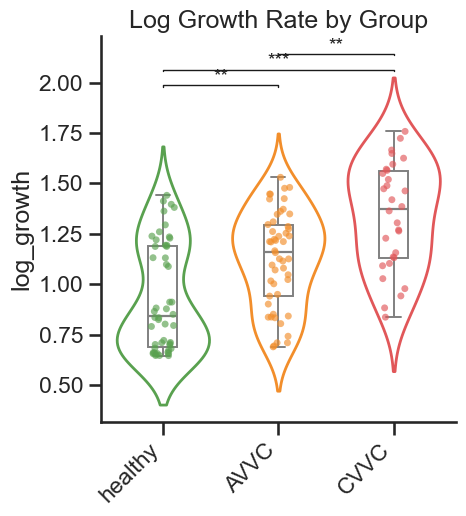

In [21]:
order = ['healthy','AVVC','CVVC']
fig, summary = plot_violinplot_ind(df, 'group', 'log_growth', title='Log Growth Rate by Group', group_order=order)

In [22]:
import os

filename = "invade0.1_log-growth-violins-new"
save_path = "/Users/mengya/SDU/GSMM/mt_project/results_new/"

png_file = os.path.join(save_path, f"{filename}.png")
pdf_file = os.path.join(save_path, f"{filename}.pdf")

# fig.savefig(png_file, bbox_inches='tight', dpi=300)
# fig.savefig(pdf_file, bbox_inches='tight')

In [23]:
print(df.shape, df['group'].value_counts())

(130, 12) group
healthy    50
AVVC       50
CVVC       30
Name: count, dtype: int64


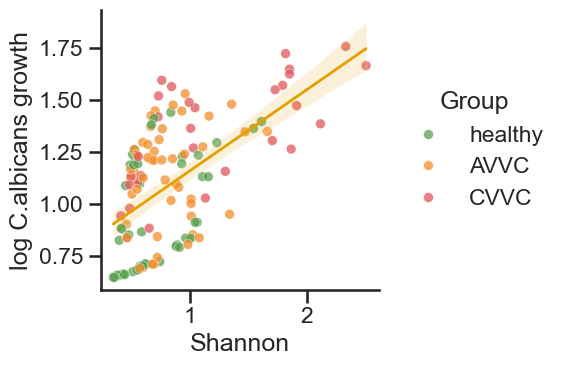

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
palette = {"healthy":"#59A14F",
            "AVVC":"#F28E2B",
            "CVVC":"#E15759",
           }

# 1) 按组别上色散点
sns.scatterplot(
    data=df, x="shannon", y="log_growth",
    hue="group", palette=palette,
    s=50, alpha=0.75,
    edgecolor="white", linewidth=0.4,
    ax=ax
)

# 2) 叠加一条总体回归线（不分组）
sns.regplot(
    data=df, x="shannon", y="log_growth",
    scatter=False, color="#E69F00",
    line_kws={"lw": 2},
    ax=ax
)

ax.set_xlabel("Shannon")
ax.set_ylabel("log C.albicans growth")

# 图例位置与样式
ax.legend(title="Group",frameon=False,loc="center left",bbox_to_anchor=(1.02, 0.5))

sns.despine()
plt.tight_layout()

# plt.savefig('/Users/mengya/SDU/GSMM/mt_project/results_new/log-cal-vs-shannon.pdf',bbox_inches='tight')
# plt.savefig("/Users/mengya/SDU/GSMM/mt_project/results_new/log-cal-vs-shannon.png",bbox_inches='tight', dpi=300)

In [26]:
dat = df.copy()
dat = dat[["log_growth", "shannon", "group"]].dropna()

X = sm.add_constant(dat[["shannon"]])   # 只加一次截距
y = dat["log_growth"]

m = sm.OLS(y, X).fit(cov_type="HC3")   # 推荐稳健标准误
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:             log_growth   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     122.2
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           2.36e-20
Time:                        16:55:09   Log-Likelihood:                0.75388
No. Observations:                 130   AIC:                             2.492
Df Residuals:                     128   BIC:                             8.227
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7664      0.041     18.753      0.0

In [27]:
# 疾病严重程度与Shannon指数相关性
from scipy.stats import spearmanr

severity_map = {"healthy": 0, "AVVC": 1, "CVVC": 2}
df["severity"] = df["group"].map(severity_map)

# Spearman correlation
rho, p = spearmanr(df["severity"], df["shannon"], nan_policy="omit")
rho, p

(0.36325309220491964, 2.1592638258361045e-05)

## Global trends

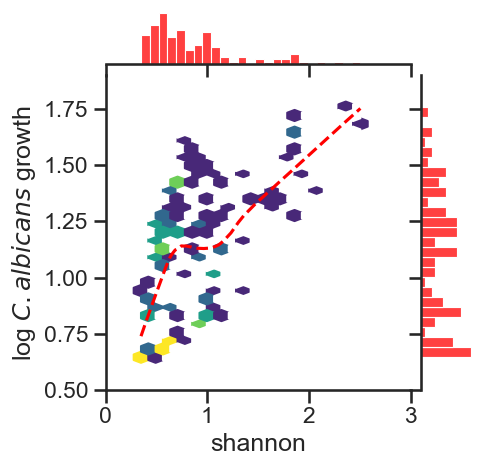

In [28]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl # 引入 mpl 以使用新的 colormaps API

colors = sns.color_palette('colorblind')
lowess = sm.nonparametric.lowess

temp = cal_growth.copy()

# 计算 Lowess 拟合曲线
fit = lowess(temp.log_growth, temp.shannon)

# 处理异常值/截断值
idx = temp[temp.log_growth < -6].index.values
temp.loc[idx, 'log_growth'] = -6

# 绘图
my_viridis = mpl.colormaps["viridis"].resampled(1024).with_extremes(under="white")
g = sns.jointplot(x='shannon', y='log_growth', 
                  kind="hex", 
                  data=temp,
                  height=5,
                  joint_kws={'gridsize': (15, 15), 
                             'vmin': 0.5, 
                             'vmax': 5, 
                             'cmap': my_viridis}, # palette参数在hex模式下通常不需要，cmap控制颜色
                  marginal_kws={'bins': 25, 'color': 'red'})

# 设置坐标轴范围
g.ax_joint.set_ylim(0.5, 1.9)
g.ax_joint.set_xlim(0.0, 3.0)

# 在主图上添加拟合曲线
g.ax_joint.plot(fit[:, 0], fit[:, 1], color='red', linestyle='--')

# 设置 Y 轴标签
g.ax_joint.set_ylabel('log $C.albicans$ growth')

# # 保存图片
# plt.savefig("/Users/mengya/SDU/GSMM/mt_project/results_new/Shannon-vs-logrowth-Full.png", bbox_inches='tight', dpi=300)
# plt.savefig("/Users/mengya/SDU/GSMM/mt_project/results_new/Shannon-vs-logrowth-Full.pdf", bbox_inches='tight', dpi=300)

plt.show()

## Fluxes

In [32]:
fluxes = pd.read_pickle('/Users/mengya/SDU/GSMM/mt_project/results_new/final_invade0.1_fluxes_tradeoff0.8_pfba-new.pkl')
fluxes.index = pd.MultiIndex.from_tuples([tuple(x) for x in growth_rates[['sample','compartments']].values])
fluxes = fluxes.fillna(10**-6).drop('sample',axis=1)
fluxes

reaction                            12DGR180tex  12DGR180ti  12DGR180tipp  \
H19 Acinetobacter_guillouiae           0.000001    0.000001      0.000001   
    Acinetobacter_johnsonii            0.000001    0.000001      0.000001   
    Aspergillus_oryzae                 0.000001    0.000001      0.000001   
    Bacillus_cereus                    0.000001    0.000001      0.000001   
    Bacillus_mycoides                  0.000001    0.000022      0.000001   
...                                         ...         ...           ...   
V3  Thermothelomyces_thermophilus      0.000001    0.000001      0.000001   
    Thermothielavioides_terrestris     0.000001    0.000001      0.000001   
    Ustilaginoidea_virens              0.000001    0.000001      0.000001   
    Yersinia_enterocolitica            0.000001    0.000001      0.000001   
    community                          0.000001    0.000001      0.000001   

reaction                            12PPD_Stex    12PPDt  12PPDtpp    15DAPt  \
H19 Acinetobacter_guillouiae          0.000001  0.000001  0.000001  0.000001   
    Acinetobacter_johnsonii           0.000001  0.000001  0.000001  0.000001   
    Aspergillus_oryzae                0.000001  0.000001  0.000001  0.000001   
    Bacillus_cereus                   0.000001  0.000001  0.000001  0.000001   
    Bacillus_mycoides                 0.000001  0.000001  0.000001  0.000001   
...                                        ...       ...       ...       ...   
V3  Thermothelomyces_thermophilus     0.000001  0.000001  0.000001  0.000001   
    Thermothielavioides_terrestris    0.000001  0.000001  0.000001  0.000001   
    Ustilaginoidea_virens             0.000001  0.000001  0.000001  0.000001   
    Yersinia_enterocolitica           0.000001  0.000001  0.000001  0.000001   
    community                         0.000001  0.000001  0.000001  0.000001   

reaction                             1H2NPTH  1P4H2CBXLAH       23DHMPO  ...  \
H19 Acinetobacter_guillouiae        0.000000     0.000001 -2.236345e-06  ...   
    Acinetobacter_johnsonii         0.000001     0.000000 -1.137340e-06  ...   
    Aspergillus_oryzae              0.000001     0.000001  1.000000e-06  ...   
    Bacillus_cereus                 0.000000     0.000004 -2.502375e-06  ...   
    Bacillus_mycoides               0.000001     0.000004 -2.799222e-06  ...   
...                                      ...          ...           ...  ...   
V3  Thermothelomyces_thermophilus   0.000001     0.000001  1.000000e-06  ...   
    Thermothielavioides_terrestris  0.000001     0.000001  1.000000e-06  ...   
    Ustilaginoidea_virens           0.000001     0.000001  1.000000e-06  ...   
    Yersinia_enterocolitica         0.000001     0.000000 -6.325097e-07  ...   
    community                       0.000001     0.000001  1.000000e-06  ...   

reaction                             SPHK21c  TSULt2pp  biomass047  \
H19 Acinetobacter_guillouiae        0.000001  0.000001    0.000001   
    Acinetobacter_johnsonii         0.000001  0.000001    0.000001   
    Aspergillus_oryzae              0.000001  0.000001    0.000001   
    Bacillus_cereus                 0.000001  0.000001    0.000001   
    Bacillus_mycoides               0.000001  0.000001    0.000001   
...                                      ...       ...         ...   
V3  Thermothelomyces_thermophilus   0.000001  0.000001    0.000001   
    Thermothielavioides_terrestris  0.000001  0.000001    0.000001   
    Ustilaginoidea_virens           0.000001  0.000001    0.000001   
    Yersinia_enterocolitica         0.000001  0.000001    0.000001   
    community                       0.000001  0.000001    0.000001   

reaction                            biomass074  biomass164  biomass179  \
H19 Acinetobacter_guillouiae          0.000001    0.000001    0.000001   
    Acinetobacter_johnsonii           0.000001    0.000001    0.000001   
    Aspergillus_oryzae                0.000001    0.000001    0.000001   
    Bacillus_cer

In [33]:
exchanges = fluxes.filter(regex=r'^EX_|_E$')
exchanges

reaction                            EX_10Ehpda_m  EX_10Zhpda_m  \
H19 Acinetobacter_guillouiae        1.000000e-06  1.000000e-06   
    Acinetobacter_johnsonii         1.000000e-06  1.000000e-06   
    Aspergillus_oryzae              1.000000e-06  1.000000e-06   
    Bacillus_cereus                 1.000000e-06  1.000000e-06   
    Bacillus_mycoides               1.000000e-06  1.000000e-06   
...                                          ...           ...   
V3  Thermothelomyces_thermophilus   1.000000e-06  1.000000e-06   
    Thermothielavioides_terrestris  1.000000e-06  1.000000e-06   
    Ustilaginoidea_virens           1.000000e-06  1.000000e-06   
    Yersinia_enterocolitica         1.000000e-06  1.000000e-06   
    community                       4.064543e-07  4.234447e-07   

reaction                            EX_124bztriol_m  EX_12dgr180(e)  \
H19 Acinetobacter_guillouiae           1.000000e-06        0.000001   
    Acinetobacter_johnsonii            1.000000e-06        0.000001   
    Aspergillus_oryzae                 1.000000e-06        0.000001   
    Bacillus_cereus                    1.000000e-06        0.000001   
    Bacillus_mycoides                  1.000000e-06       -0.000022   
...                                             ...             ...   
V3  Thermothelomyces_thermophilus      1.000000e-06        0.000001   
    Thermothielavioides_terrestris     1.000000e-06        0.000001   
    Ustilaginoidea_virens              1.000000e-06        0.000001   
    Yersinia_enterocolitica            1.000000e-06        0.000001   
    community                          3.409996e-07        0.000001   

reaction                            EX_12dgr180_m   EX_12ethd_m  \
H19 Acinetobacter_guillouiae             0.000001  1.000000e-06   
    Acinetobacter_johnsonii              0.000001  1.000000e-06   
    Aspergillus_oryzae                   0.000001  1.000000e-06   
    Bacillus_cereus                      0.000001  1.000000e-06   
    Bacillus_mycoides                    0.000001  1.000000e-06   
...                                           ...           ...   
V3  Thermothelomyces_thermophilus        0.000001  1.000000e-06   
    Thermothielavioides_terrestris       0.000001  1.000000e-06   
    Ustilaginoidea_virens                0.000001  1.000000e-06   
    Yersinia_enterocolitica              0.000001  1.000000e-06   
    community                           -0.985158  1.072298e-07   

reaction                            EX_12ppd_S(e)  EX_12ppd_S_m  \
H19 Acinetobacter_guillouiae             0.000001  1.000000e-06   
    Acinetobacter_johnsonii              0.000001  1.000000e-06   
    Aspergillus_oryzae                   0.000001  1.000000e-06   
    Bacillus_cereus                      0.000001  1.000000e-06   
    Bacillus_mycoides                    0.000001  1.000000e-06   
...                                           ...           ...   
V3  Thermothelomyces_thermophilus        0.000001  1.000000e-06   
    Thermothielavioides_terrestris       0.000001  1.000000e-06   
    Ustilaginoidea_virens                0.000001  1.000000e-06   
    Yersinia_enterocolitica              0.000001  1.000000e-06   
    community                            0.000001 -1.997805e-07   

reaction                            EX_13BDglcn_m   EX_14bxyl_m  ...  \
H19 Acinetobacter_guillouiae         1.000000e-06  1.000000e-06  ...   
    Acinetobacter_johnsonii          1.000000e-06  1.000000e-06  ...   
    Aspergillus_oryzae               1.000000e-06  1.000000e-06  ...   
    Bacillus_cereus                  1.000000e-06  1.000000e-06  ...   
    Bacillus_mycoides                1.000000e-06  1.000000e-06  ...   
...                                           ...           ...  ...   
V3  Thermothelomyces_thermophilus    1.000000e-06  1.000000e-06  ...   
    Thermothielavioides_terrestris   1.000000e-06  1.000000e-06  ...   
    Ustilaginoidea_virens            1.000000e-06  1.000000e-06  ...   
    Yersinia_enterocolit

In [34]:
import_flux = exchanges.copy()[[x[1] != 'community' for x in exchanges.index]]
import_flux[import_flux >=0]=10**-6
import_flux=abs(import_flux)
import_flux=np.log10(import_flux)
import_flux=import_flux[import_flux>-6].fillna(-6)

export_flux = exchanges.copy()[[x[1] != 'community' for x in exchanges.index]]
export_flux[export_flux<=0]=10**-6
export_flux=np.log10(export_flux)
export_flux[export_flux<-6]=-6
export_flux

reaction                            EX_10Ehpda_m  EX_10Zhpda_m  \
H19 Acinetobacter_guillouiae                -6.0          -6.0   
    Acinetobacter_johnsonii                 -6.0          -6.0   
    Aspergillus_oryzae                      -6.0          -6.0   
    Bacillus_cereus                         -6.0          -6.0   
    Bacillus_mycoides                       -6.0          -6.0   
...                                          ...           ...   
V3  Talaromyces_marneffei                   -6.0          -6.0   
    Thermothelomyces_thermophilus           -6.0          -6.0   
    Thermothielavioides_terrestris          -6.0          -6.0   
    Ustilaginoidea_virens                   -6.0          -6.0   
    Yersinia_enterocolitica                 -6.0          -6.0   

reaction                            EX_124bztriol_m  EX_12dgr180(e)  \
H19 Acinetobacter_guillouiae                   -6.0            -6.0   
    Acinetobacter_johnsonii                    -6.0            -6.0   
    Aspergillus_oryzae                         -6.0            -6.0   
    Bacillus_cereus                            -6.0            -6.0   
    Bacillus_mycoides                          -6.0            -6.0   
...                                             ...             ...   
V3  Talaromyces_marneffei                      -6.0            -6.0   
    Thermothelomyces_thermophilus              -6.0            -6.0   
    Thermothielavioides_terrestris             -6.0            -6.0   
    Ustilaginoidea_virens                      -6.0            -6.0   
    Yersinia_enterocolitica                    -6.0            -6.0   

reaction                            EX_12dgr180_m  EX_12ethd_m  EX_12ppd_S(e)  \
H19 Acinetobacter_guillouiae                 -6.0         -6.0           -6.0   
    Acinetobacter_johnsonii                  -6.0         -6.0           -6.0   
    Aspergillus_oryzae                       -6.0         -6.0           -6.0   
    Bacillus_cereus                          -6.0         -6.0           -6.0   
    Bacillus_mycoides                        -6.0         -6.0           -6.0   
...                                           ...          ...            ...   
V3  Talaromyces_marneffei                    -6.0         -6.0           -6.0   
    Thermothelomyces_thermophilus            -6.0         -6.0           -6.0   
    Thermothielavioides_terrestris           -6.0         -6.0           -6.0   
    Ustilaginoidea_virens                    -6.0         -6.0           -6.0   
    Yersinia_enterocolitica                  -6.0         -6.0           -6.0   

reaction                            EX_12ppd_S_m  EX_13BDglcn_m  EX_14bxyl_m  \
H19 Acinetobacter_guillouiae                -6.0           -6.0         -6.0   
    Acinetobacter_johnsonii                 -6.0           -6.0         -6.0   
    Aspergillus_oryzae                      -6.0           -6.0         -6.0   
    Bacillus_cereus                         -6.0           -6.0         -6.0   
    Bacillus_mycoides                       -6.0           -6.0         -6.0   
...                                          ...            ...          ...   
V3  Talaromyces_marneffei                   -6.0           -6.0         -6.0   
    Thermothelomyces_thermophilus           -6.0           -6.0         -6.0   
    Thermothielavioides_terrestris          -6.0           -6.0         -6.0   
    Ustilaginoidea_virens                   -6.0           -6.0         -6.0   
    Yersinia_enterocolitica                 -6.0           -6.0         -6.0   

reaction                            ...  EX_digitoxin(e)  EX_digitoxin_m  \
H19 Acinetobacter_guillouiae        ...             -6.0            -6.0   
    Acinetobacter_johnsonii         ...             -6.0            -6.0   
    Aspergillus_oryzae              ...             -6.0            -6.0   
    Bacillus_cereus                 ...             -6.0            -6.0   
    Bacillus_mycoides               ... 

In [35]:
imprts=import_flux.reset_index()
imprts=imprts[imprts.level_1=='Candida_albicans']
cal_rate=growth_rates[growth_rates.compartments=='Candida_albicans']
cal_import=pd.merge(imprts,cal_rate,left_on='level_0',right_on='sample')
cal_import=cal_import.drop(['level_0','level_1'],axis=1)
cal_import['log_growth']=np.log10(cal_import.growth_rate)
cal_import

,EX_10Ehpda_m,EX_10Zhpda_m,EX_124bztriol_m,EX_12dgr180(e),EX_12dgr180_m,EX_12ethd_m,EX_12ppd_S(e),EX_12ppd_S_m,EX_13BDglcn_m,EX_14bxyl_m,...,EX_h2o2_m,EX_mtym(e),EX_mtym_m,compartments,growth_rate,abundance,sample,condition,tradeoff,log_growth
0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,4.556773,0.100010,H19,0.1cal-invaded,0.8,0.658657
1,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,6.673522,0.100005,H38,0.1cal-invaded,0.8,0.824355
2,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,14.337558,0.100005,V22,0.1cal-invaded,0.8,1.156475
3,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,18.575157,0.100000,C19,0.1cal-invaded,0.8,1.268932
4,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,16.598956,0.100005,H47,0.1cal-invaded,0.8,1.220081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,19.332995,0.100000,V30,0.1cal-invaded,0.8,1.286299
126,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,4.890763,0.100005,V44,0.1cal-invaded,0.8,0.689377
127,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,12.014719,0.100019,V36,0.1cal-invaded,0.8,1.079714
128,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,11.764806,0.100014,V34,0.1cal-invaded,0.8,1.070585


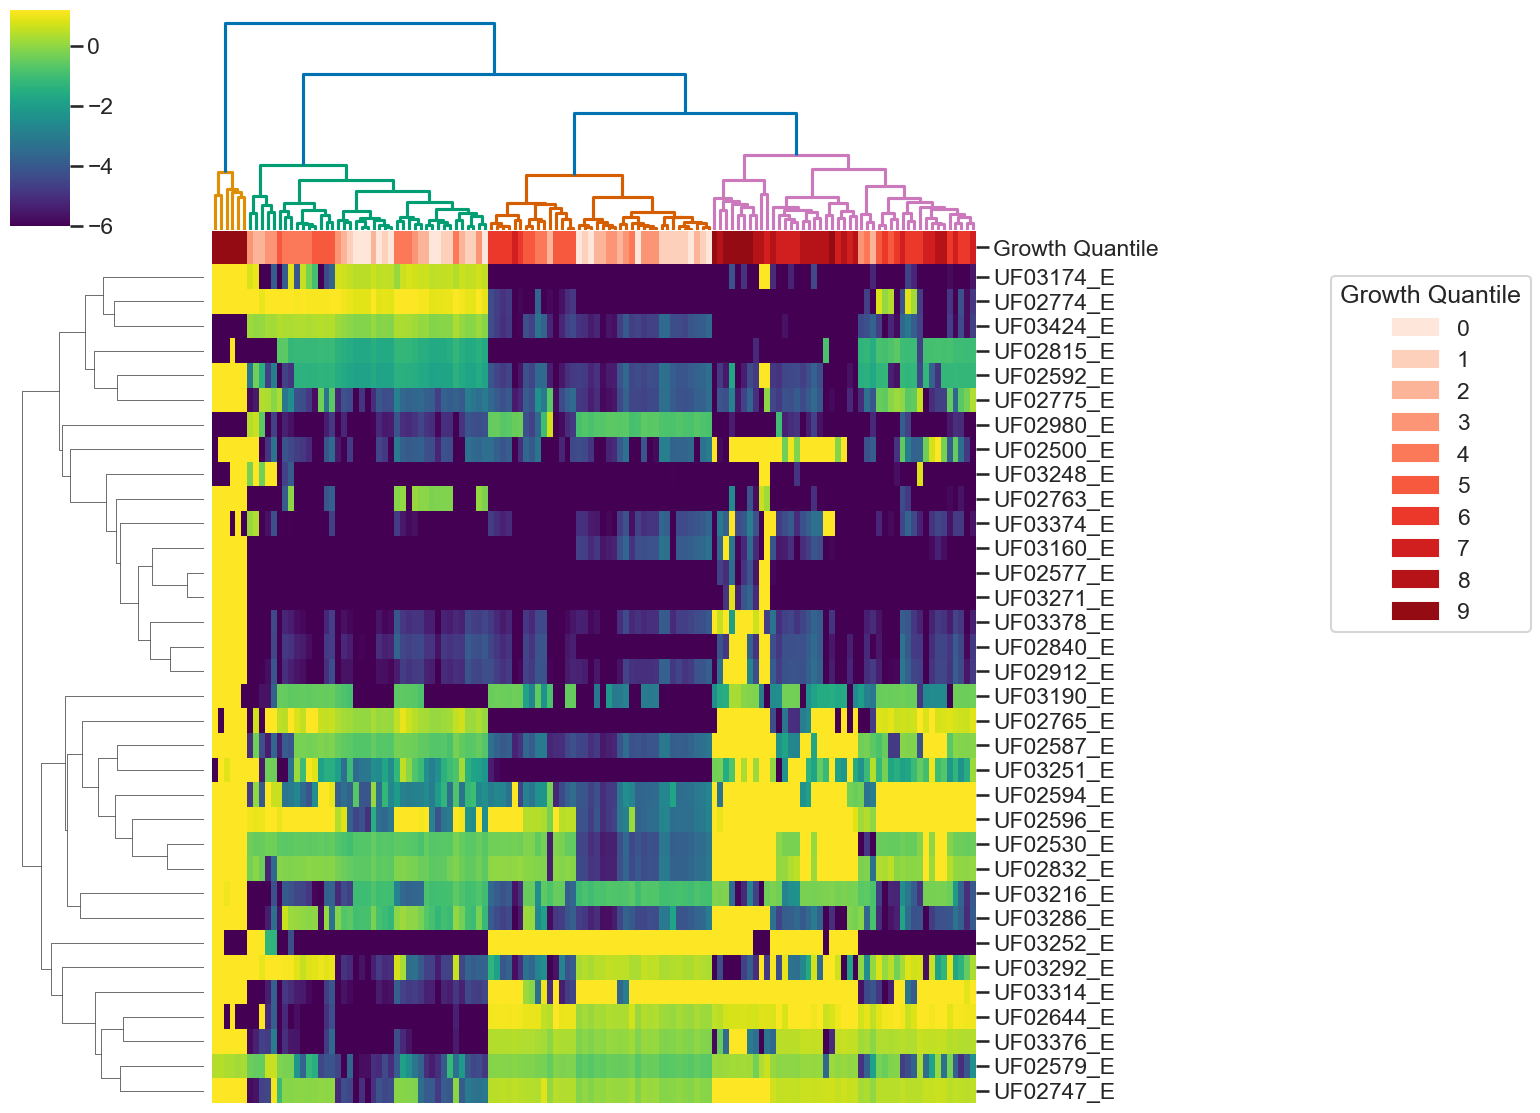

In [83]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

df = cal_import.copy()

# --- 1. 预先计算 Linkage 和 Cluster ---
max_d = 95
X = df.iloc[:, :-8]  
Z = linkage(X, 'ward')

# 这里我们先创建一个临时的 dendrogram 仅仅为了获取默认的颜色字典
dendro_info = dendrogram(Z, color_threshold=max_d, no_plot=True) # no_plot=True 防止它直接画出来
clusters = fcluster(Z, max_d, criterion='distance')

# 准备颜色数据
df['Cluster'] = clusters
n = 10
df['Growth Quantile'] = pd.qcut(df.log_growth, n, labels=False)
colors_reds = sns.color_palette('Reds', n)
cmap_quantile = {group: colors_reds[i] for i, group in enumerate(sorted(df['Growth Quantile'].unique()))}
col_colors = df['Growth Quantile'].map(cmap_quantile)

num_cols = df.select_dtypes(include=['number']).columns[:-7]
variances = df[num_cols].var()
idx = variances[variances >= 3.5].index

# --- 2. 绘制 Clustermap ---
clust = sns.clustermap(df.loc[:, idx].T,
                      cmap='viridis',
                      vmin=-6,
                      vmax=1.2,
                      figsize=(12, 12),
                      col_linkage=Z,  # 使用我们预先算好的 Z
                      col_colors=col_colors,
                      yticklabels=1,
                      linewidths=0)

# --- 3. 给顶部树状图上色 ---

# 获取树状图的线条集合
# clust.dendrogram_col.linkage 存储了聚类信息，但我们需要绘制时的颜色
# Seaborn 默认是用黑色画的，我们需要根据 scipy 的计算结果重新赋值颜色
# 获取 scipy 计算出的颜色列表 (dendro_info['color_list'])
# 注意：Scipy 和 Seaborn 绘制树状图的顺序可能不完全一致，但如果传入 col_linkage=Z 通常是一致的

# 获取顶部树状图的轴对象
ax_col_dendro = clust.ax_col_dendrogram

# 清除 Seaborn 默认画的黑色线条
ax_col_dendro.collections[0].remove() 

# 使用 scipy 的 dendrogram 在该轴上重新绘制一遍带颜色的
dendrogram(Z, 
           color_threshold=max_d, 
           ax=ax_col_dendro, 
           orientation='top',
           link_color_func=None, # 使用默认颜色生成逻辑
           above_threshold_color='#0072B2') # 阈值以上的颜色

# 重新调整坐标轴以匹配 Seaborn 的布局
ax_col_dendro.set_xlim([0, len(X)*10]) # scipy dendrogram 默认间距是 10
ax_col_dendro.axis('off') # 再次关闭坐标轴显示

# --- 后续美化 (保持您之前的代码) ---
order = [x.get_text() for x in clust.ax_heatmap.get_xticklabels()]
clust.ax_heatmap.set_ylabel('')
clust.ax_heatmap.set_xlabel('')
clust.ax_heatmap.set_xticks([])

# 去除多余边框
clust.ax_heatmap.spines['top'].set_visible(False)
clust.ax_heatmap.spines['right'].set_visible(False)
clust.ax_heatmap.spines['bottom'].set_visible(False)
clust.ax_heatmap.spines['left'].set_visible(False)
if clust.ax_col_colors:
    for spine in clust.ax_col_colors.spines.values():
        spine.set_visible(False)
    for collection in clust.ax_col_colors.collections:
        collection.set_linewidth(0)

handles = []
labels = sorted(df['Growth Quantile'].unique())
for i, label in enumerate(labels):
    patch = mpatches.Patch(color=colors_reds[i], label=label)
    handles.append(patch)
clust.ax_heatmap.legend(handles=handles, bbox_to_anchor=(1.45, 1), loc=2, title='Growth Quantile')

# # 保存热图
plt.savefig('/Users/mengya/SDU/GSMM/mt_project/results_new/Cal_invade-ImportHeatmap-final.pdf', bbox_inches='tight')

# # 保存包含分簇结果的表格
df.to_csv('/Users/mengya/SDU/GSMM/mt_project/results_new/Cal_invade_with_Im_clusters-final.csv', index=False)

plt.show()

In [37]:
exprts=export_flux.reset_index()
exprts=exprts[exprts.level_1=='Candida_albicans']
cal_rate=growth_rates[growth_rates.compartments=='Candida_albicans']
cal_export=pd.merge(exprts,cal_rate,left_on='level_0',right_on='sample')
cal_export=cal_export.drop(['level_0','level_1'],axis=1)
cal_export['log_growth']=np.log10(cal_export.growth_rate)
cal_export

,EX_10Ehpda_m,EX_10Zhpda_m,EX_124bztriol_m,EX_12dgr180(e),EX_12dgr180_m,EX_12ethd_m,EX_12ppd_S(e),EX_12ppd_S_m,EX_13BDglcn_m,EX_14bxyl_m,...,EX_h2o2_m,EX_mtym(e),EX_mtym_m,compartments,growth_rate,abundance,sample,condition,tradeoff,log_growth
0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,4.556773,0.100010,H19,0.1cal-invaded,0.8,0.658657
1,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,6.673522,0.100005,H38,0.1cal-invaded,0.8,0.824355
2,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,14.337558,0.100005,V22,0.1cal-invaded,0.8,1.156475
3,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,18.575157,0.100000,C19,0.1cal-invaded,0.8,1.268932
4,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,16.598956,0.100005,H47,0.1cal-invaded,0.8,1.220081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,19.332995,0.100000,V30,0.1cal-invaded,0.8,1.286299
126,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,4.890763,0.100005,V44,0.1cal-invaded,0.8,0.689377
127,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,12.014719,0.100019,V36,0.1cal-invaded,0.8,1.079714
128,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,Candida_albicans,11.764806,0.100014,V34,0.1cal-invaded,0.8,1.070585


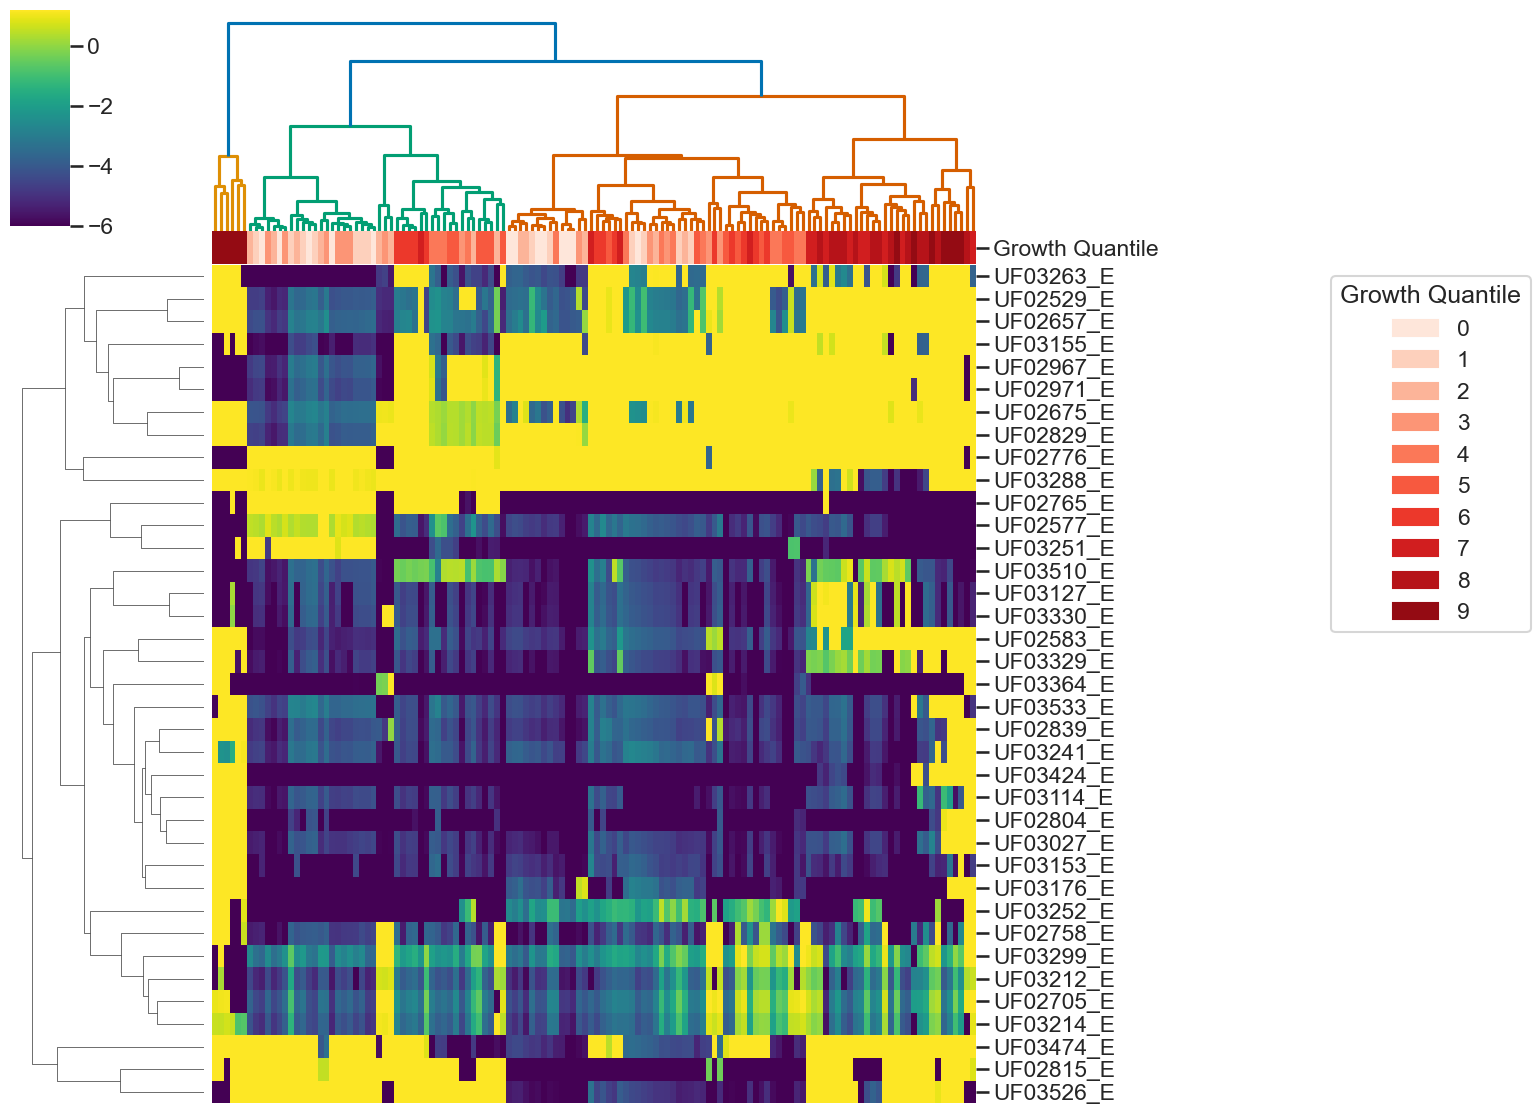

In [84]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

df2 = cal_export.copy()

# --- 1. 预先计算 Linkage 和 Cluster ---
max_d = 100
X = df2.iloc[:, :-8]  
Z = linkage(X, 'ward')

# 这里我们先创建一个临时的 dendrogram 仅仅为了获取默认的颜色字典
dendro_info = dendrogram(Z, color_threshold=max_d, no_plot=True) # no_plot=True 防止它直接画出来
clusters = fcluster(Z, max_d, criterion='distance')

# 准备颜色数据
df2['Cluster'] = clusters
n = 10
df2['Growth Quantile'] = pd.qcut(df2.log_growth, n, labels=False)
colors_reds = sns.color_palette('Reds', n)
cmap_quantile = {group: colors_reds[i] for i, group in enumerate(sorted(df2['Growth Quantile'].unique()))}
col_colors = df2['Growth Quantile'].map(cmap_quantile)

num_cols = df2.select_dtypes(include=['number']).columns[:-7]
variances = df2[num_cols].var()
idx = variances[variances >= 3.5].index

# --- 2. 绘制 Clustermap ---
clust = sns.clustermap(df2.loc[:, idx].T,
                      cmap='viridis',
                      vmin=-6,
                      vmax=1.2,
                      figsize=(12, 12),
                      col_linkage=Z,  # 使用我们预先算好的 Z
                      col_colors=col_colors,
                      yticklabels=1,
                      linewidths=0)

# --- 3. 给顶部树状图上色 ---

# 获取树状图的线条集合
# clust.dendrogram_col.linkage 存储了聚类信息，但我们需要绘制时的颜色
# Seaborn 默认是用黑色画的，我们需要根据 scipy 的计算结果重新赋值颜色
# 获取 scipy 计算出的颜色列表 (dendro_info['color_list'])
# 注意：Scipy 和 Seaborn 绘制树状图的顺序可能不完全一致，但如果传入 col_linkage=Z 通常是一致的

# 获取顶部树状图的轴对象
ax_col_dendro = clust.ax_col_dendrogram

# 清除 Seaborn 默认画的黑色线条
ax_col_dendro.collections[0].remove() 

# 使用 scipy 的 dendrogram 在该轴上重新绘制一遍带颜色的
dendrogram(Z, 
           color_threshold=max_d, 
           ax=ax_col_dendro, 
           orientation='top',
           link_color_func=None, # 使用默认颜色生成逻辑
           above_threshold_color='#0072B2') # 阈值以上的颜色

# 重新调整坐标轴以匹配 Seaborn 的布局
ax_col_dendro.set_xlim([0, len(X)*10]) # scipy dendrogram 默认间距是 10
ax_col_dendro.axis('off') # 再次关闭坐标轴显示

# --- 后续美化 (保持您之前的代码) ---
order = [x.get_text() for x in clust.ax_heatmap.get_xticklabels()]
clust.ax_heatmap.set_ylabel('')
clust.ax_heatmap.set_xlabel('')
clust.ax_heatmap.set_xticks([])

# 去除多余边框
clust.ax_heatmap.spines['top'].set_visible(False)
clust.ax_heatmap.spines['right'].set_visible(False)
clust.ax_heatmap.spines['bottom'].set_visible(False)
clust.ax_heatmap.spines['left'].set_visible(False)
if clust.ax_col_colors:
    for spine in clust.ax_col_colors.spines.values():
        spine.set_visible(False)
    for collection in clust.ax_col_colors.collections:
        collection.set_linewidth(0)

handles = []
labels = sorted(df2['Growth Quantile'].unique())
for i, label in enumerate(labels):
    patch = mpatches.Patch(color=colors_reds[i], label=label)
    handles.append(patch)
clust.ax_heatmap.legend(handles=handles, bbox_to_anchor=(1.45, 1), loc=2, title='Growth Quantile')

# 保存热图
plt.savefig('/Users/mengya/SDU/GSMM/mt_project/results_new/Cal_invade-ExportHeatmap-final.pdf', bbox_inches='tight')

# 保存包含分簇结果的表格
df2.to_csv('/Users/mengya/SDU/GSMM/mt_project/results_new/Cal_invade_with_Ex_clusters-final.csv', index=False)

plt.show()

## UMAP

In [47]:
import re

def group_key3(name):

    pattern = r'-\d+$'
    if re.search(pattern, name):
        return 'after'
    else:
        if name.startswith('C') or name.startswith('V'):
            return 'AVVC'
        elif name.startswith('S') or name.startswith('R'):
            return 'CVVC'
        elif name.startswith('H'):
            return 'healthy'
        else:
            return 'unknown'

In [40]:
import_med = exchanges.copy()[[x[1] == 'community' for x in exchanges.index]]
import_med[import_med>=0]=10**-6
import_med=abs(import_med)
import_med=np.log10(import_med)
import_med.index=import_med.index.droplevel(1)

export_med = exchanges.copy()[[x[1] == 'community' for x in exchanges.index]]
export_med[export_med<=0]=10**-6
export_med=np.log10(export_med)
export_med.index=export_med.index.droplevel(1)
export_med

reaction,EX_10Ehpda_m,EX_10Zhpda_m,EX_124bztriol_m,EX_12dgr180(e),EX_12dgr180_m,EX_12ethd_m,EX_12ppd_S(e),EX_12ppd_S_m,EX_13BDglcn_m,EX_14bxyl_m,...,EX_digitoxin(e),EX_digitoxin_m,EX_dihydro_digitoxin(e),EX_dihydro_digitoxin_m,EX_dihydro_digoxin(e),EX_dihydro_digoxin_m,EX_h2o2(e),EX_h2o2_m,EX_mtym(e),EX_mtym_m
H19,-7.995827,-7.955195,-6.057328,-6.0,-6.0,-6.225354,-6.0,-6.0,-7.394269,-7.507629,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
H38,-7.084780,-6.624632,-6.164306,-6.0,-6.0,-6.827522,-6.0,-6.0,-7.098105,-7.153543,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
V22,-8.230379,-8.526464,-6.552088,-6.0,-6.0,-6.901404,-6.0,-6.0,-7.482605,-7.057221,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
C19,-9.457646,-9.456926,-8.149449,-6.0,-6.0,-7.963714,-6.0,-6.0,-8.910990,-8.822925,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
H47,-7.513089,-5.641949,-5.401846,-6.0,-6.0,-5.243422,-6.0,-6.0,-6.214654,-5.984225,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V30,-9.006005,-8.736440,-6.357081,-6.0,-6.0,-6.499511,-6.0,-6.0,-7.431305,-7.097358,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
V44,-7.034832,-7.024578,-4.949868,-6.0,-6.0,-5.222983,-6.0,-6.0,-6.050103,-5.823063,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
V36,-8.054034,-5.335771,-6.350104,-6.0,-6.0,-6.284950,-6.0,-6.0,-7.321214,-7.049411,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
V34,-8.198914,-8.055484,-5.745824,-6.0,-6.0,-5.850047,-6.0,-6.0,-7.212870,-6.818606,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0


In [41]:
import_med=import_med[import_med>-6].fillna(-6)
cols=import_med.columns[import_med.mean(axis=0)>-6]
umap = UMAP()
df=import_med[cols].copy()
fit= umap.fit(df)
coord =fit.embedding_
umap_imprt=pd.DataFrame(coord)
umap_imprt.columns=['x','y']
umap_imprt.index=import_med.index

export_med=export_med[export_med>-6].fillna(-6)
cols=export_med.columns[export_med.mean(axis=0)>-6]
umap = UMAP()
df=export_med[cols].copy()
fit= umap.fit(df)
coord =fit.embedding_
umap_exprt=pd.DataFrame(coord)
umap_exprt.columns=['x','y']
umap_exprt.index=export_med.index

In [42]:
umap_imprt

,x,y
H19,2.472954,4.456063
H38,18.702763,7.372376
V22,18.367620,7.067452
C19,17.990885,5.964283
H47,16.272396,4.160195
...,...,...
V30,16.346281,4.292264
V44,2.679341,4.039546
V36,15.201010,4.554040
V34,14.778327,3.897887


In [44]:
cal_import_med = exchanges.copy()[[x[1] == 'Candida_albicans' for x in exchanges.index]]
cal_import_med[cal_import_med>=0]=10**-6
cal_import_med=abs(cal_import_med)
cal_import_med=np.log10(cal_import_med)
cal_import_med.index=cal_import_med.index.droplevel(1)


cal_export_med = exchanges.copy()[[x[1] == 'Candida_albicans' for x in exchanges.index]]
cal_export_med[cal_export_med <=0]=10**-6
cal_export_med=np.log10(cal_export_med)
cal_export_med.index=cal_export_med.index.droplevel(1)
cal_export_med

reaction,EX_10Ehpda_m,EX_10Zhpda_m,EX_124bztriol_m,EX_12dgr180(e),EX_12dgr180_m,EX_12ethd_m,EX_12ppd_S(e),EX_12ppd_S_m,EX_13BDglcn_m,EX_14bxyl_m,...,EX_digitoxin(e),EX_digitoxin_m,EX_dihydro_digitoxin(e),EX_dihydro_digitoxin_m,EX_dihydro_digoxin(e),EX_dihydro_digoxin_m,EX_h2o2(e),EX_h2o2_m,EX_mtym(e),EX_mtym_m
H19,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
H38,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
V22,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
C19,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
H47,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V30,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
V44,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
V36,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0
V34,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,...,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0,-6.0


In [45]:
cols=cal_import_med.columns[cal_import_med.mean(axis=0)>-6]
umap = UMAP()
df=cal_import_med[cols].copy()
fit= umap.fit(df)
coord =fit.embedding_
umap_cal_im=pd.DataFrame(coord)
umap_cal_im.columns=['x','y']
umap_cal_im.index=cal_import_med.index
umap_cal_im

,x,y
H19,8.676373,-2.783664
H38,8.734531,-2.238003
V22,7.721608,0.695228
C19,7.836709,1.340035
H47,5.562555,4.254245
...,...,...
V30,5.667439,3.729271
V44,8.149590,-3.614377
V36,1.155168,3.876152
V34,0.898604,4.198141


In [46]:
cols=cal_export_med.columns[cal_export_med.mean(axis=0)>-6]
umap = UMAP()
df=cal_export_med[cols].copy()
fit= umap.fit(df)
coord =fit.embedding_
umap_cal_ex=pd.DataFrame(coord)
umap_cal_ex.columns=['x','y']
umap_cal_ex.index=cal_export_med.index
umap_cal_ex

,x,y
H19,7.204402,3.846178
H38,7.347852,3.276860
V22,9.289877,7.100644
C19,9.862431,8.220338
H47,12.316800,10.748242
...,...,...
V30,11.474759,10.535735
V44,6.428050,4.274237
V36,11.295180,11.594669
V34,11.775976,12.124539


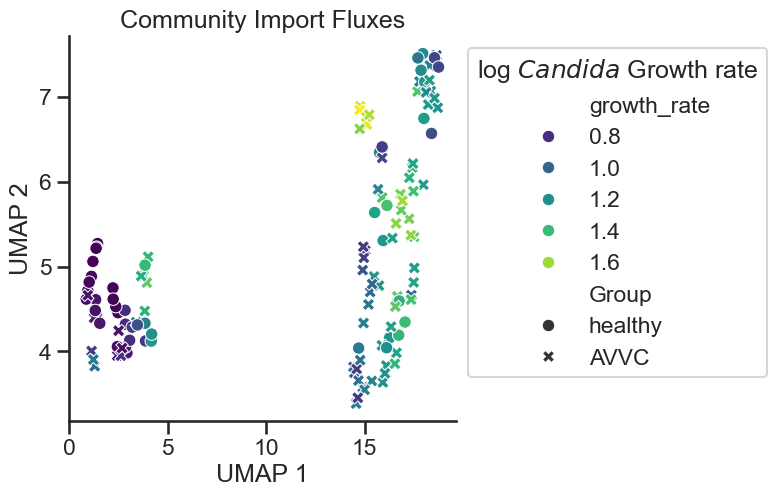

In [48]:
plt.figure(figsize=(5,5))
df = umap_imprt
group = df.index.to_series().apply(group_key3)
group.name = 'Group'

hue = growth_data_grouped[growth_data_grouped.compartments == 'Candida_albicans'][['growth_rate','sample','compartments']].copy()
hue.index = hue['sample']
hue = hue.loc[df.index]
hue = np.log10(hue['growth_rate'])

# idx = hue[hue < -6].index
# hue.loc[idx] = -6

sns.scatterplot(x=df['x'], y=df['y'], hue=hue, style=group, palette='viridis')
plt.legend(bbox_to_anchor=(1,1), title='log $Candida$ Growth rate')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Community Import Fluxes')
# plt.savefig('/Users/mengya/SDU/GSMM/mt_project/results_new/Cal_invade-Community_Import_Fluxes.pdf', bbox_inches='tight')
plt.show()

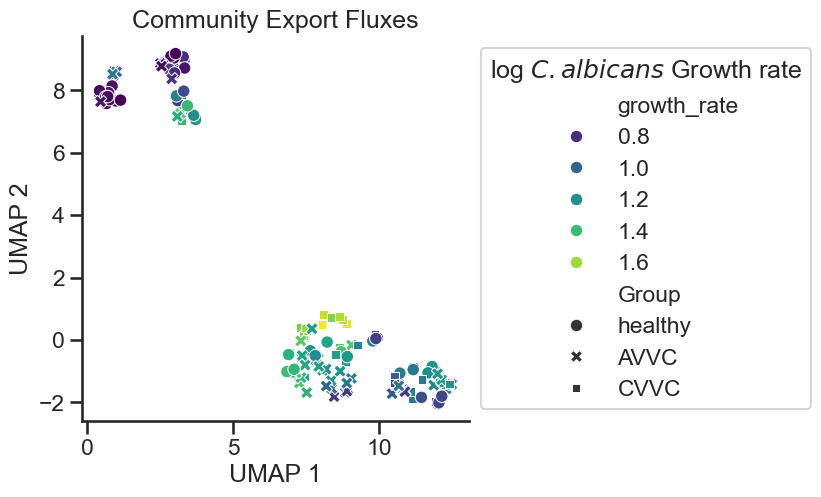

In [49]:
plt.figure(figsize=(5,5))
df = umap_exprt
group = df.index.to_series().apply(group_key)
group.name = 'Group'

hue = growth_data_grouped[growth_data_grouped.compartments == 'Candida_albicans'][['growth_rate','sample','compartments']].copy()
hue.index = hue['sample']
hue = hue.loc[df.index]
hue = np.log10(hue['growth_rate'])

idx = hue[hue < -6].index
hue.loc[idx] = -6

sns.scatterplot(x=df['x'], y=df['y'], hue=hue, style=group, palette='viridis')
plt.legend(bbox_to_anchor=(1,1), title='log $C.albicans$ Growth rate')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Community Export Fluxes')
plt.show()

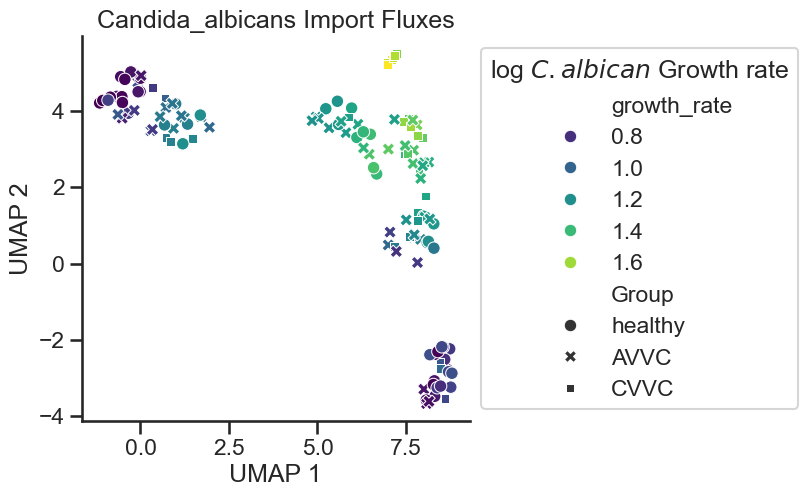

In [50]:
plt.figure(figsize=(5,5))
df = umap_cal_im
group = df.index.to_series().apply(group_key)
group.name = 'Group'

hue = growth_data_grouped[growth_data_grouped.compartments == 'Candida_albicans'][['growth_rate','sample','compartments']].copy()
hue.index = hue['sample']
hue = hue.loc[df.index]
hue = np.log10(hue['growth_rate'])

sns.scatterplot(x=df['x'], y=df['y'], hue=hue, style=group, palette='viridis')
plt.legend(bbox_to_anchor=(1,1), title='log $C.albican$ Growth rate')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Candida_albicans Import Fluxes')
plt.show()

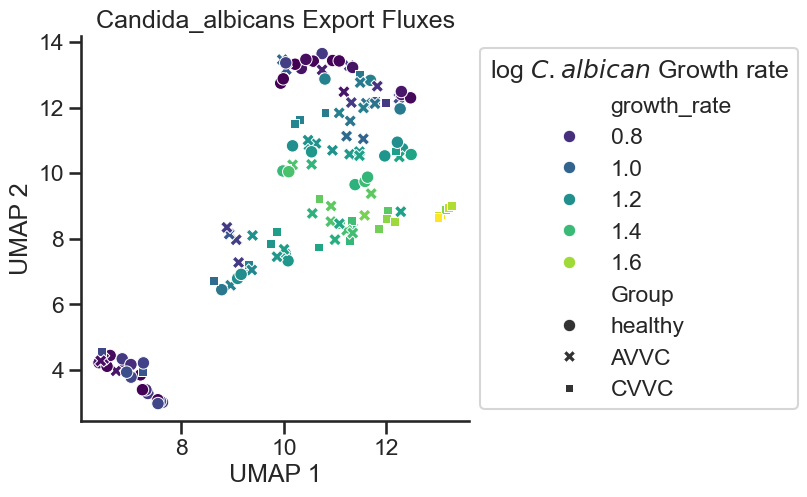

In [51]:
plt.figure(figsize=(5,5))
df = umap_cal_ex
group = df.index.to_series().apply(group_key)
group.name = 'Group'

hue = growth_data_grouped[growth_data_grouped.compartments == 'Candida_albicans'][['growth_rate','sample','compartments']].copy()
hue.index = hue['sample']
hue = hue.loc[df.index]
hue = np.log10(hue['growth_rate'])

sns.scatterplot(x=df['x'], y=df['y'], hue=hue, style=group, palette='viridis')
plt.legend(bbox_to_anchor=(1,1), title='log $C.albican$ Growth rate')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('Candida_albicans Export Fluxes')
plt.show()

## Probiotics 1

In [52]:
growth_rates_prob=pd.read_pickle(r'/Users/mengya/SDU/GSMM/mt_project/results_new/final_prob0.7-treat1_growth_rates_tradeoff_0.8.pkl').reset_index()
growth_rates_prob

,compartments,growth_rate,abundance,sample,condition,tradeoff
0,Aspergillus_oryzae,0.006375,0.000105,V10,0.1cal-0.7prob,0.8
1,Candida_albicans,6.084526,0.100205,V10,0.1cal-0.7prob,0.8
2,Enterococcus_faecalis,0.004694,0.000077,V10,0.1cal-0.7prob,0.8
3,Finegoldia_magna,0.010537,0.000174,V10,0.1cal-0.7prob,0.8
4,Granulicatella_adiacens,0.005804,0.000055,V10,0.1cal-0.7prob,0.8
...,...,...,...,...,...,...
2858,Stenotrophomonas_maltophilia,0.229934,0.004275,C24,0.1cal-0.7prob,0.8
2859,Streptococcus_pyogenes,0.019068,0.000355,C24,0.1cal-0.7prob,0.8
2860,Yersinia_enterocolitica,0.048255,0.000897,C24,0.1cal-0.7prob,0.8
2861,_Ruminococcus_torques,0.003138,0.000059,C24,0.1cal-0.7prob,0.8


In [53]:
# +probiotic
growth_data_prob = compute_alpha_diversity(growth_rates_prob)
growth_data_prob

,compartments,growth_rate,abundance,sample,condition,tradeoff,log_growth,shannon,otus,simpson,quantile
0,Aspergillus_oryzae,0.006375,0.000105,V10,0.1cal-0.7prob,0.8,-2.195537,0.892665,12,0.156913,"(0.869, 0.91]"
1,Candida_albicans,6.084526,0.100205,V10,0.1cal-0.7prob,0.8,0.784227,0.892665,12,0.156913,"(0.869, 0.91]"
2,Enterococcus_faecalis,0.004694,0.000077,V10,0.1cal-0.7prob,0.8,-2.328461,0.892665,12,0.156913,"(0.869, 0.91]"
3,Finegoldia_magna,0.010537,0.000174,V10,0.1cal-0.7prob,0.8,-1.977273,0.892665,12,0.156913,"(0.869, 0.91]"
4,Granulicatella_adiacens,0.005804,0.000055,V10,0.1cal-0.7prob,0.8,-2.236265,0.892665,12,0.156913,"(0.869, 0.91]"
...,...,...,...,...,...,...,...,...,...,...,...
2858,Stenotrophomonas_maltophilia,0.229934,0.004275,C24,0.1cal-0.7prob,0.8,-0.638397,0.790318,47,0.031917,"(0.758, 0.815]"
2859,Streptococcus_pyogenes,0.019068,0.000355,C24,0.1cal-0.7prob,0.8,-1.719692,0.790318,47,0.031917,"(0.758, 0.815]"
2860,Yersinia_enterocolitica,0.048255,0.000897,C24,0.1cal-0.7prob,0.8,-1.316456,0.790318,47,0.031917,"(0.758, 0.815]"
2861,_Ruminococcus_torques,0.003138,0.000059,C24,0.1cal-0.7prob,0.8,-2.503332,0.790318,47,0.031917,"(0.758, 0.815]"


In [54]:
def group_key2(name):
    name = str(name)
    if name.startswith(('C')):
        return 'CVVC+prob'
    elif name.startswith(('V')):
        return 'AVVC+prob'
    elif name.startswith('H'):
        return 'healthy+prob'

In [55]:
# +probiotic
growth_data_prob_grouped = growth_data_prob.copy()
growth_data_prob_grouped['group'] = growth_data_prob_grouped['sample'].apply(group_key2)
growth_data_prob_grouped

,compartments,growth_rate,abundance,sample,condition,tradeoff,log_growth,shannon,otus,simpson,quantile,group
0,Aspergillus_oryzae,0.006375,0.000105,V10,0.1cal-0.7prob,0.8,-2.195537,0.892665,12,0.156913,"(0.869, 0.91]",AVVC+prob
1,Candida_albicans,6.084526,0.100205,V10,0.1cal-0.7prob,0.8,0.784227,0.892665,12,0.156913,"(0.869, 0.91]",AVVC+prob
2,Enterococcus_faecalis,0.004694,0.000077,V10,0.1cal-0.7prob,0.8,-2.328461,0.892665,12,0.156913,"(0.869, 0.91]",AVVC+prob
3,Finegoldia_magna,0.010537,0.000174,V10,0.1cal-0.7prob,0.8,-1.977273,0.892665,12,0.156913,"(0.869, 0.91]",AVVC+prob
4,Granulicatella_adiacens,0.005804,0.000055,V10,0.1cal-0.7prob,0.8,-2.236265,0.892665,12,0.156913,"(0.869, 0.91]",AVVC+prob
...,...,...,...,...,...,...,...,...,...,...,...,...
2858,Stenotrophomonas_maltophilia,0.229934,0.004275,C24,0.1cal-0.7prob,0.8,-0.638397,0.790318,47,0.031917,"(0.758, 0.815]",CVVC+prob
2859,Streptococcus_pyogenes,0.019068,0.000355,C24,0.1cal-0.7prob,0.8,-1.719692,0.790318,47,0.031917,"(0.758, 0.815]",CVVC+prob
2860,Yersinia_enterocolitica,0.048255,0.000897,C24,0.1cal-0.7prob,0.8,-1.316456,0.790318,47,0.031917,"(0.758, 0.815]",CVVC+prob
2861,_Ruminococcus_torques,0.003138,0.000059,C24,0.1cal-0.7prob,0.8,-2.503332,0.790318,47,0.031917,"(0.758, 0.815]",CVVC+prob


In [56]:
# +probiotic
cal_growth_prob=growth_data_prob_grouped[(growth_data_prob_grouped.compartments=='Candida_albicans')]
cal_growth_prob

,compartments,growth_rate,abundance,sample,condition,tradeoff,log_growth,shannon,otus,simpson,quantile,group
1,Candida_albicans,6.084526,0.100205,V10,0.1cal-0.7prob,0.8,0.784227,0.892665,12,0.156913,"(0.869, 0.91]",AVVC+prob
15,Candida_albicans,6.420752,0.100311,V39,0.1cal-0.7prob,0.8,0.807586,0.950310,12,0.159547,"(0.946, 1.063]",AVVC+prob
28,Candida_albicans,18.104274,0.100277,H27,0.1cal-0.7prob,0.8,1.257781,0.829827,15,0.123428,"(0.815, 0.83]",healthy+prob
45,Candida_albicans,5.972439,0.100422,V14,0.1cal-0.7prob,0.8,0.776152,0.824629,14,0.131979,"(0.815, 0.83]",AVVC+prob
59,Candida_albicans,10.278652,0.100467,H32,0.1cal-0.7prob,0.8,1.011936,0.941773,17,0.111562,"(0.91, 0.946]",healthy+prob
...,...,...,...,...,...,...,...,...,...,...,...,...
2688,Candida_albicans,5.972742,0.100357,V26,0.1cal-0.7prob,0.8,0.776174,0.822310,25,0.073893,"(0.815, 0.83]",AVVC+prob
2717,Candida_albicans,6.028374,0.100764,H47,0.1cal-0.7prob,0.8,0.780200,0.834616,22,0.083687,"(0.83, 0.846]",healthy+prob
2734,Candida_albicans,7.314571,0.106995,C21,0.1cal-0.7prob,0.8,0.864189,0.857516,43,0.036745,"(0.846, 0.869]",CVVC+prob
2777,Candida_albicans,11.559852,0.113277,C18,0.1cal-0.7prob,0.8,1.062952,0.803360,39,0.039726,"(0.758, 0.815]",CVVC+prob


In [57]:
group = cal_growth_prob[cal_growth_prob['group'].isin(["AVVC+prob", "CVVC+prob"])]
# group = cal_growth_prob[cal_growth_prob['group'].isin(["AVVC+iners", "CVVC+iners"])].drop(columns=['prob_weight'], errors='ignore')
cols = sorted(set(cal_growth.columns) | set(group.columns))
cal2 = cal_growth.reindex(columns=cols)
gr2 = group.reindex(columns=cols)
combined = pd.concat([cal2, gr2], ignore_index=True, sort=False)
combined

,abundance,compartments,condition,group,growth_rate,log_growth,otus,quantile,sample,shannon,simpson,tradeoff
0,0.100010,Candida_albicans,0.1cal-invaded,healthy,4.556773,0.658657,26,"(0.348, 0.445]",H19,0.402951,0.047964,0.8
1,0.100005,Candida_albicans,0.1cal-invaded,healthy,6.673522,0.824355,36,"(0.348, 0.445]",H38,0.400766,0.034532,0.8
2,0.100005,Candida_albicans,0.1cal-invaded,AVVC,14.337558,1.156475,39,"(0.512, 0.565]",V22,0.525124,0.033812,0.8
3,0.100000,Candida_albicans,0.1cal-invaded,CVVC,18.575157,1.268932,39,"(0.972, 1.067]",C19,1.032605,0.053622,0.8
4,0.100005,Candida_albicans,0.1cal-invaded,healthy,16.598956,1.220081,52,"(0.512, 0.565]",H47,0.536750,0.025014,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...
205,0.100346,Candida_albicans,0.1cal-0.7prob,AVVC+prob,6.040885,0.781101,17,"(0.83, 0.846]",V22,0.837907,0.109016,0.8
206,0.100357,Candida_albicans,0.1cal-0.7prob,AVVC+prob,5.972742,0.776174,25,"(0.815, 0.83]",V26,0.822310,0.073893,0.8
207,0.106995,Candida_albicans,0.1cal-0.7prob,CVVC+prob,7.314571,0.864189,43,"(0.846, 0.869]",C21,0.857516,0.036745,0.8
208,0.113277,Candida_albicans,0.1cal-0.7prob,CVVC+prob,11.559852,1.062952,39,"(0.758, 0.815]",C18,0.803360,0.039726,0.8


In [58]:
df2=combined.copy()
print(df2)
idx=df2[df2['log_growth']<-6].index
df2.loc[idx,'log_growth']=-6

     abundance      compartments       condition      group  growth_rate  \
0     0.100010  Candida_albicans  0.1cal-invaded    healthy     4.556773   
1     0.100005  Candida_albicans  0.1cal-invaded    healthy     6.673522   
2     0.100005  Candida_albicans  0.1cal-invaded       AVVC    14.337558   
3     0.100000  Candida_albicans  0.1cal-invaded       CVVC    18.575157   
4     0.100005  Candida_albicans  0.1cal-invaded    healthy    16.598956   
..         ...               ...             ...        ...          ...   
205   0.100346  Candida_albicans  0.1cal-0.7prob  AVVC+prob     6.040885   
206   0.100357  Candida_albicans  0.1cal-0.7prob  AVVC+prob     5.972742   
207   0.106995  Candida_albicans  0.1cal-0.7prob  CVVC+prob     7.314571   
208   0.113277  Candida_albicans  0.1cal-0.7prob  CVVC+prob    11.559852   
209   0.114867  Candida_albicans  0.1cal-0.7prob  CVVC+prob     6.178883   

     log_growth  otus        quantile sample   shannon   simpson  tradeoff  
0      0.6

In [59]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import scikit_posthocs as sp


def plot_violinplot3_dn_bh(data, group_col, value_col, title=None, alpha=0.05,
                           return_fig=True, show=True, group_order=None):

    fig, ax = plt.subplots(figsize=(5, 5.5))
    groups = list(data[group_col].dropna().unique()) if group_order is None else list(group_order)

    color = {
        "healthy":   "#59A14F",
        "AVVC":      "#F28E2B",
        "CVVC":      "#E15759",
        "AVVC+prob": "#4E79A7",
        "CVVC+prob": "#B07AA1",
    }
    palette = [color.get(g, "#999999") for g in groups]
    palette_map = dict(zip(groups, palette))

    # violin
    sns.violinplot(
        data=data, x=group_col, y=value_col, order=groups,
        hue=group_col, palette=palette_map, legend=False,
        inner=None, cut=2, bw_adjust=1.0,
        linewidth=2, saturation=1, ax=ax
    )
    for i, pc in enumerate(ax.collections[:len(groups)]):
        pc.set_facecolor((0, 0, 0, 0))
        pc.set_edgecolor(palette[i])
        pc.set_linewidth(2)

    # box
    sns.boxplot(
        data=data, x=group_col, y=value_col, order=groups,
        hue=group_col, palette=palette_map, legend=False,
        width=0.25, showfliers=False,
        boxprops=dict(facecolor="white", edgecolor="grey", linewidth=1.4),
        whiskerprops=dict(color="grey", linewidth=1.4),
        capprops=dict(color="grey", linewidth=1.4),
        medianprops=dict(color="grey", linewidth=1.6),
        ax=ax
    )

    # points
    sns.stripplot(
        data=data, x=group_col, y=value_col, order=groups,
        hue=group_col, palette=palette_map,
        jitter=True, dodge=False, size=5.0, alpha=0.65, linewidth=0, ax=ax
    )

    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

    ax.set_title('')
    ax.set_xlabel('')
    if value_col == 'growth_rate':
        ax.set_ylabel(r'$C.\,albicans$ growth')
    elif value_col == 'log_growth':
        ax.set_ylabel(r'log $C.\,albicans$ growth')
    else:
        ax.set_ylabel(value_col)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    # --- Kruskal–Wallis omnibus ---
    samples = [data.loc[data[group_col] == g, value_col].dropna() for g in groups]
    samples_nonempty = [s for s in samples if len(s) > 0]

    kw_p = np.nan
    if len(samples_nonempty) >= 2:
        try:
            _, kw_p = kruskal(*samples_nonempty)
        except Exception:
            kw_p = np.nan

    if np.isfinite(kw_p):
        ax.set_title((title if title else f"{value_col} by Group"))

    # --- Post hoc: Dunn + BH-FDR (only if omnibus significant) ---
    if np.isfinite(kw_p) and kw_p < alpha:

        # Dunn：先得到未校正 p（ties 会处理），再统一做 BH-FDR
        pmat = sp.posthoc_dunn(
            data[[group_col, value_col]].dropna(),
            val_col=value_col, group_col=group_col,
            p_adjust=None, sort=False
        )

        pairs = list(itertools.combinations(groups, 2))
        pvals = []
        for g1, g2 in pairs:
            if (g1 in pmat.index) and (g2 in pmat.columns):
                pvals.append(float(pmat.loc[g1, g2]))
            else:
                pvals.append(np.nan)

        pvals = np.asarray(pvals, dtype=float)
        mask = np.isfinite(pvals)
        pvals_corr = np.full_like(pvals, np.nan, dtype=float)
        if mask.sum() > 0:
            pvals_corr[mask] = multipletests(pvals[mask], alpha=alpha, method="fdr_bh")[1]

        def add_significance_bar(x1, x2, y, h, text):
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='k')
            ax.text((x1 + x2) * 0.5, y + h*0.3, text,
                    ha='center', va='bottom', color='k', fontsize=14)

        pos = {g: i for i, g in enumerate(groups)}
        vals = data[value_col].dropna()

        if vals.size > 0:
            y_max = vals.max() * 1.1
            step = (vals.max() - vals.min()) * 0.05 if (vals.max() - vals.min()) != 0 else 0.1
            cur_y = y_max + step * 0.6

            for (g1, g2), p_corr in zip(pairs, pvals_corr):
                if np.isfinite(p_corr) and p_corr < alpha:
                    if p_corr < 0.001:
                        stars = '***'
                    elif p_corr < 0.01:
                        stars = '**'
                    elif p_corr < 0.05:
                        stars = '*'
                    else:
                        stars = ''
                    if stars:
                        add_significance_bar(pos[g1], pos[g2], cur_y, step*0.02, stars)
                        cur_y += step * 1.05

    plt.tight_layout()
    if show:
        plt.show()
    return fig if return_fig else None

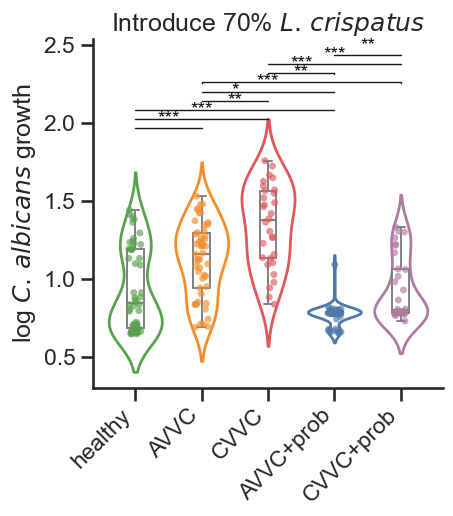

In [61]:
order = ['healthy','AVVC','CVVC','AVVC+prob','CVVC+prob']

fig = plot_violinplot3_dn_bh(
    data=df2,
    group_col="group",
    value_col="log_growth",
    title=r"Introduce 70% $L.\,crispatus$",
    # title=r"Introduce 70% $L.\,iners$",
    alpha=0.05,
    group_order=order,
    show=True,
    return_fig=True
)

In [62]:
filename = "invade0.1+prob0.7-treat1_log-growth-violins-new"
# filename = "invade0.1+iners0.7_log-growth-violins-new"
# fig.savefig(f"/Users/mengya/SDU/GSMM/mt_project/results_new/{filename}.png", bbox_inches='tight', dpi=300)
# fig.savefig(f"/Users/mengya/SDU/GSMM/mt_project/results_new/{filename}.pdf", bbox_inches='tight')

## Probiotics 2

In [65]:
import pandas as pd
import glob

# 读取所有匹配模式的文件
prob_ratios = [round(x, 1) for x in [i/10 for i in range(2, 8)]] 
file_pattern = '/Users/mengya/SDU/GSMM/mt_project/results_new/final_prob*-treat1_growth_rates_tradeoff_0.8.pkl'
files = sorted(glob.glob(file_pattern))

# 读取并合并所有文件
growth_rates_prob_all = pd.concat([pd.read_pickle(f).reset_index() for f in files], ignore_index=True)
growth_rates_prob_all

,compartments,growth_rate,abundance,sample,condition,tradeoff
0,Aerococcus_christensenii,0.356901,0.002706,H17,0.1cal-0.2prob,0.8
1,Aspergillus_oryzae,0.070903,0.000538,H17,0.1cal-0.2prob,0.8
2,Bacillus_cereus,0.012803,0.000097,H17,0.1cal-0.2prob,0.8
3,Bacillus_velezensis,0.012510,0.000095,H17,0.1cal-0.2prob,0.8
4,Botrytis_cinerea,0.031289,0.000237,H17,0.1cal-0.2prob,0.8
...,...,...,...,...,...,...
26051,Stenotrophomonas_maltophilia,0.229934,0.004275,C24,0.1cal-0.7prob,0.8
26052,Streptococcus_pyogenes,0.019068,0.000355,C24,0.1cal-0.7prob,0.8
26053,Yersinia_enterocolitica,0.048255,0.000897,C24,0.1cal-0.7prob,0.8
26054,_Ruminococcus_torques,0.003138,0.000059,C24,0.1cal-0.7prob,0.8


In [66]:
growth_rates_prob_all['condition'].drop_duplicates()

0        0.1cal-0.2prob
5611     0.1cal-0.3prob
10775    0.1cal-0.4prob
15450    0.1cal-0.5prob
19620    0.1cal-0.6prob
23193    0.1cal-0.7prob
Name: condition, dtype: object

In [67]:
import numpy as np

# 从 condition 提取 cal 和 prob（支持小数）
m = growth_rates_prob_all['condition'].str.extract(
    r'(?P<cal_lvl>\d*\.?\d+)\s*cal-(?P<prob_lvl>\d*\.?\d+)\s*prob'
)

growth_rates_prob_all['cal_lvl'] = m['cal_lvl'].astype(float)
growth_rates_prob_all['prob_lvl'] = m['prob_lvl'].astype(float)
growth_rates_grouped_prob_all

,compartments,growth_rate,abundance,sample,condition,tradeoff,cal_lvl,prob_lvl
0,Aerococcus_christensenii,0.356901,0.002706,H17,0.1cal-0.2prob,0.8,0.1,0.2
1,Aspergillus_oryzae,0.070903,0.000538,H17,0.1cal-0.2prob,0.8,0.1,0.2
2,Bacillus_cereus,0.012803,0.000097,H17,0.1cal-0.2prob,0.8,0.1,0.2
3,Bacillus_velezensis,0.012510,0.000095,H17,0.1cal-0.2prob,0.8,0.1,0.2
4,Botrytis_cinerea,0.031289,0.000237,H17,0.1cal-0.2prob,0.8,0.1,0.2
...,...,...,...,...,...,...,...,...
26051,Stenotrophomonas_maltophilia,0.229934,0.004275,C24,0.1cal-0.7prob,0.8,0.1,0.7
26052,Streptococcus_pyogenes,0.019068,0.000355,C24,0.1cal-0.7prob,0.8,0.1,0.7
26053,Yersinia_enterocolitica,0.048255,0.000897,C24,0.1cal-0.7prob,0.8,0.1,0.7
26054,_Ruminococcus_torques,0.003138,0.000059,C24,0.1cal-0.7prob,0.8,0.1,0.7


In [69]:
growth_rates['condition']='0.1cal-invade'
growth_rates['cal_lvl']=0.1
growth_rates['prob_lvl']=0.0
growth_rates

,compartments,growth_rate,abundance,sample,condition,tradeoff,cal_lvl,prob_lvl
0,Acinetobacter_guillouiae,0.002653,0.000058,H19,0.1cal-invade,0.8,0.1,0.0
1,Acinetobacter_johnsonii,0.005450,0.000067,H19,0.1cal-invade,0.8,0.1,0.0
2,Aspergillus_oryzae,0.011974,0.000263,H19,0.1cal-invade,0.8,0.1,0.0
3,Bacillus_cereus,0.008628,0.000190,H19,0.1cal-invade,0.8,0.1,0.0
4,Bacillus_mycoides,0.002776,0.000061,H19,0.1cal-invade,0.8,0.1,0.0
...,...,...,...,...,...,...,...,...
6486,Thermothelomyces_thermophilus,0.009734,0.000051,V3,0.1cal-invade,0.8,0.1,0.0
6487,Thermothielavioides_terrestris,0.012555,0.000067,V3,0.1cal-invade,0.8,0.1,0.0
6488,Ustilaginoidea_virens,0.014317,0.000076,V3,0.1cal-invade,0.8,0.1,0.0
6489,Yersinia_enterocolitica,0.021483,0.000114,V3,0.1cal-invade,0.8,0.1,0.0


In [70]:
growth_rates_grouped = growth_rates.copy()
growth_rates_grouped['group'] = growth_rates_grouped['sample'].apply(group_key)
growth_rates_grouped

,compartments,growth_rate,abundance,sample,condition,tradeoff,cal_lvl,prob_lvl,group
0,Acinetobacter_guillouiae,0.002653,0.000058,H19,0.1cal-invade,0.8,0.1,0.0,healthy
1,Acinetobacter_johnsonii,0.005450,0.000067,H19,0.1cal-invade,0.8,0.1,0.0,healthy
2,Aspergillus_oryzae,0.011974,0.000263,H19,0.1cal-invade,0.8,0.1,0.0,healthy
3,Bacillus_cereus,0.008628,0.000190,H19,0.1cal-invade,0.8,0.1,0.0,healthy
4,Bacillus_mycoides,0.002776,0.000061,H19,0.1cal-invade,0.8,0.1,0.0,healthy
...,...,...,...,...,...,...,...,...,...
6486,Thermothelomyces_thermophilus,0.009734,0.000051,V3,0.1cal-invade,0.8,0.1,0.0,AVVC
6487,Thermothielavioides_terrestris,0.012555,0.000067,V3,0.1cal-invade,0.8,0.1,0.0,AVVC
6488,Ustilaginoidea_virens,0.014317,0.000076,V3,0.1cal-invade,0.8,0.1,0.0,AVVC
6489,Yersinia_enterocolitica,0.021483,0.000114,V3,0.1cal-invade,0.8,0.1,0.0,AVVC


In [72]:
growth_rates_grouped_prob_all = growth_rates_prob_all.copy()
growth_rates_grouped_prob_all['group'] = growth_rates_grouped_prob_all['sample'].apply(group_key2)
growth_rates_grouped_prob_all

,compartments,growth_rate,abundance,sample,condition,tradeoff,cal_lvl,prob_lvl,group
0,Aerococcus_christensenii,0.356901,0.002706,H17,0.1cal-0.2prob,0.8,0.1,0.2,healthy+prob
1,Aspergillus_oryzae,0.070903,0.000538,H17,0.1cal-0.2prob,0.8,0.1,0.2,healthy+prob
2,Bacillus_cereus,0.012803,0.000097,H17,0.1cal-0.2prob,0.8,0.1,0.2,healthy+prob
3,Bacillus_velezensis,0.012510,0.000095,H17,0.1cal-0.2prob,0.8,0.1,0.2,healthy+prob
4,Botrytis_cinerea,0.031289,0.000237,H17,0.1cal-0.2prob,0.8,0.1,0.2,healthy+prob
...,...,...,...,...,...,...,...,...,...
26051,Stenotrophomonas_maltophilia,0.229934,0.004275,C24,0.1cal-0.7prob,0.8,0.1,0.7,CVVC+prob
26052,Streptococcus_pyogenes,0.019068,0.000355,C24,0.1cal-0.7prob,0.8,0.1,0.7,CVVC+prob
26053,Yersinia_enterocolitica,0.048255,0.000897,C24,0.1cal-0.7prob,0.8,0.1,0.7,CVVC+prob
26054,_Ruminococcus_torques,0.003138,0.000059,C24,0.1cal-0.7prob,0.8,0.1,0.7,CVVC+prob


In [73]:
growth_rates_grouped_all = pd.concat([growth_rates_grouped,growth_rates_grouped_prob_all], axis=0, ignore_index=True)
growth_rates_grouped_all

,compartments,growth_rate,abundance,sample,condition,tradeoff,cal_lvl,prob_lvl,group
0,Acinetobacter_guillouiae,0.002653,0.000058,H19,0.1cal-invade,0.8,0.1,0.0,healthy
1,Acinetobacter_johnsonii,0.005450,0.000067,H19,0.1cal-invade,0.8,0.1,0.0,healthy
2,Aspergillus_oryzae,0.011974,0.000263,H19,0.1cal-invade,0.8,0.1,0.0,healthy
3,Bacillus_cereus,0.008628,0.000190,H19,0.1cal-invade,0.8,0.1,0.0,healthy
4,Bacillus_mycoides,0.002776,0.000061,H19,0.1cal-invade,0.8,0.1,0.0,healthy
...,...,...,...,...,...,...,...,...,...
32542,Stenotrophomonas_maltophilia,0.229934,0.004275,C24,0.1cal-0.7prob,0.8,0.1,0.7,CVVC+prob
32543,Streptococcus_pyogenes,0.019068,0.000355,C24,0.1cal-0.7prob,0.8,0.1,0.7,CVVC+prob
32544,Yersinia_enterocolitica,0.048255,0.000897,C24,0.1cal-0.7prob,0.8,0.1,0.7,CVVC+prob
32545,_Ruminococcus_torques,0.003138,0.000059,C24,0.1cal-0.7prob,0.8,0.1,0.7,CVVC+prob


In [86]:
cluster = pd.read_csv('/Users/mengya/SDU/GSMM/mt_project/results_new/Cal_invade_with_Im_clusters-final.csv')
cluster = cluster.iloc[:, -9:]
cluster

,compartments,growth_rate,abundance,sample,condition,tradeoff,log_growth,Cluster,Growth Quantile
0,Candida_albicans,4.556773,0.100010,H19,0.1cal-invaded,0.8,0.658657,3,0
1,Candida_albicans,6.673522,0.100005,H38,0.1cal-invaded,0.8,0.824355,3,2
2,Candida_albicans,14.337558,0.100005,V22,0.1cal-invaded,0.8,1.156475,3,5
3,Candida_albicans,18.575157,0.100000,C19,0.1cal-invaded,0.8,1.268932,3,7
4,Candida_albicans,16.598956,0.100005,H47,0.1cal-invaded,0.8,1.220081,4,6
...,...,...,...,...,...,...,...,...,...
125,Candida_albicans,19.332995,0.100000,V30,0.1cal-invaded,0.8,1.286299,4,7
126,Candida_albicans,4.890763,0.100005,V44,0.1cal-invaded,0.8,0.689377,3,1
127,Candida_albicans,12.014719,0.100019,V36,0.1cal-invaded,0.8,1.079714,2,4
128,Candida_albicans,11.764806,0.100014,V34,0.1cal-invaded,0.8,1.070585,2,4


In [88]:
cal_prob = growth_rates_grouped_all[
    growth_rates_grouped_all['compartments']=='Candida_albicans'
].reset_index(drop=True).copy()

cal_prob['log_growth']=np.log10(cal_prob.growth_rate)
cal_prob.loc[cal_prob.index[cal_prob['log_growth']<-6],'log_growth']=-6
cal_prob.index=cal_prob['sample']
cal_prob = cal_prob.drop(columns=['sample'])
cal_prob

,compartments,growth_rate,abundance,condition,tradeoff,cal_lvl,prob_lvl,group,log_growth
sample,,,,,,,,,
H19,Candida_albicans,4.556773,0.100010,0.1cal-invade,0.8,0.1,0.0,healthy,0.658657
H38,Candida_albicans,6.673522,0.100005,0.1cal-invade,0.8,0.1,0.0,healthy,0.824355
V22,Candida_albicans,14.337558,0.100005,0.1cal-invade,0.8,0.1,0.0,AVVC,1.156475
C19,Candida_albicans,18.575157,0.100000,0.1cal-invade,0.8,0.1,0.0,CVVC,1.268932
H47,Candida_albicans,16.598956,0.100005,0.1cal-invade,0.8,0.1,0.0,healthy,1.220081
...,...,...,...,...,...,...,...,...,...
V26,Candida_albicans,5.972742,0.100357,0.1cal-0.7prob,0.8,0.1,0.7,AVVC+prob,0.776174
H47,Candida_albicans,6.028374,0.100764,0.1cal-0.7prob,0.8,0.1,0.7,healthy+prob,0.780200
C21,Candida_albicans,7.314571,0.106995,0.1cal-0.7prob,0.8,0.1,0.7,CVVC+prob,0.864189


In [89]:
# cluster表里只保留 sample-Cluster 映射
cluster_map = cluster[['sample', 'Cluster']].drop_duplicates()

# 合并到 cal_prob（cal_prob 现在是 sample 为索引的话先还原成列再合并）
cal_prob = cal_prob.reset_index().rename(columns={'index': 'sample'})
cal_prob = cal_prob.merge(cluster_map, on='sample', how='left')
cal_prob = cal_prob.drop(columns=['compartments', 'abundance', 'tradeoff'])
cal_prob

,sample,growth_rate,condition,cal_lvl,prob_lvl,group,log_growth,Cluster
0,H19,4.556773,0.1cal-invade,0.1,0.0,healthy,0.658657,3
1,H38,6.673522,0.1cal-invade,0.1,0.0,healthy,0.824355,3
2,V22,14.337558,0.1cal-invade,0.1,0.0,AVVC,1.156475,3
3,C19,18.575157,0.1cal-invade,0.1,0.0,CVVC,1.268932,3
4,H47,16.598956,0.1cal-invade,0.1,0.0,healthy,1.220081,4
...,...,...,...,...,...,...,...,...
905,V26,5.972742,0.1cal-0.7prob,0.1,0.7,AVVC+prob,0.776174,2
906,H47,6.028374,0.1cal-0.7prob,0.1,0.7,healthy+prob,0.780200,4
907,C21,7.314571,0.1cal-0.7prob,0.1,0.7,CVVC+prob,0.864189,4
908,C18,11.559852,0.1cal-0.7prob,0.1,0.7,CVVC+prob,1.062952,1


In [90]:
cal_prob['prob_lvl'].drop_duplicates()

0      0.0
130    0.2
260    0.3
390    0.4
520    0.5
650    0.6
780    0.7
Name: prob_lvl, dtype: float64

In [91]:
tmp=cal_prob[['sample','log_growth','Cluster','prob_lvl']].drop_duplicates()
tmp

,sample,log_growth,Cluster,prob_lvl
0,H19,0.658657,3,0.0
1,H38,0.824355,3,0.0
2,V22,1.156475,3,0.0
3,C19,1.268932,3,0.0
4,H47,1.220081,4,0.0
...,...,...,...,...
905,V26,0.776174,2,0.7
906,H47,0.780200,4,0.7
907,C21,0.864189,4,0.7
908,C18,1.062952,1,0.7


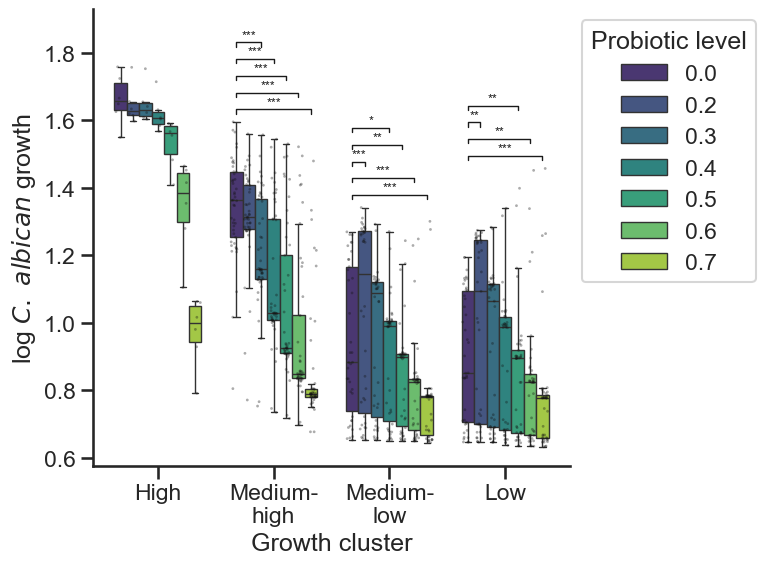

,Cluster,ref,lvl,n_pairs,p_raw,method,p_fdr,stars
3,1,0.0,0.5,6,3.125000e-02,wilcoxon,6.250000e-02,
4,1,0.0,0.6,6,3.125000e-02,wilcoxon,6.250000e-02,
5,1,0.0,0.7,6,3.125000e-02,wilcoxon,6.250000e-02,
2,1,0.0,0.4,6,6.250000e-02,wilcoxon,9.375000e-02,
0,1,0.0,0.2,6,3.125000e-01,wilcoxon,3.125000e-01,
1,1,0.0,0.3,6,3.125000e-01,wilcoxon,3.125000e-01,
23,2,0.0,0.7,41,1.081596e-05,wilcoxon,6.489578e-05,***
22,2,0.0,0.6,41,4.305447e-04,wilcoxon,1.291634e-03,**
18,2,0.0,0.2,41,3.607704e-03,wilcoxon,7.215407e-03,**
21,2,0.0,0.5,41,5.611398e-03,wilcoxon,8.417097e-03,**


In [92]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# ========= 0) 聚合 =========
df = (tmp.groupby(["sample","Cluster","prob_lvl"], as_index=False)["log_growth"].mean())

order = [1, 4, 3, 2]
hue_order = sorted(df["prob_lvl"].unique())
ref = 0.0

# ========= 1) 多重校正 =========
def bh_fdr(pvals):
    pvals = np.asarray(pvals, float)
    m = len(pvals)
    o = np.argsort(pvals)
    r = pvals[o]
    adj = r * m / (np.arange(1, m+1))
    adj = np.minimum.accumulate(adj[::-1])[::-1]
    adj = np.clip(adj, 0, 1)
    out = np.empty_like(adj)
    out[o] = adj
    return out

def p_to_stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

# ========= 2) pivot 成宽表 =========
wide = (df.pivot_table(index=["Cluster","sample"], columns="prob_lvl",values="log_growth", aggfunc="mean").sort_index())

# ========= 3) 配对 Wilcoxon =========
def paired_wilcoxon_p(diff, alternative="two-sided"):
    diff = np.asarray(diff, float)
    n = len(diff)
    if n < 2:
        return n, (1.0 if n > 0 else np.nan)
    if np.allclose(diff, 0):
        return n, 1.0
    p = float(wilcoxon(diff, alternative=alternative, zero_method="pratt", method="auto").pvalue)
    return n, p

# ========= 4) 计算检验 + 每个 cluster 内 BH-FDR =========
rows = []
ALT = "two-sided"

for cl in order:
    if cl not in wide.index.get_level_values(0):
        continue
    wide_cl = wide.loc[cl]

    for lvl in hue_order:
        if lvl == ref:
            continue

        if ref not in wide_cl.columns or lvl not in wide_cl.columns:
            rows.append({"Cluster": cl, "ref": ref, "lvl": lvl, "n_pairs": 0, "p_raw": np.nan, "method": ""})
            continue

        m = wide_cl[[ref, lvl]].dropna()
        diff = (m[lvl] - m[ref]).to_numpy()

        n_pairs, p_raw = paired_wilcoxon_p(diff, alternative=ALT)
        rows.append({"Cluster": cl, "ref": ref, "lvl": lvl,
                     "n_pairs": n_pairs, "p_raw": p_raw, "method": "wilcoxon"})

res = pd.DataFrame(rows)

res["p_fdr"] = np.nan
for cl in order:
    m = (res["Cluster"] == cl) & np.isfinite(res["p_raw"])
    if m.sum():
        res.loc[m, "p_fdr"] = bh_fdr(res.loc[m, "p_raw"].to_numpy())

res["stars"] = res["p_fdr"].map(lambda x: "" if not np.isfinite(x) else p_to_stars(x))
res_out = res.sort_values(["Cluster", "p_fdr", "p_raw", "lvl"])

# ========= 5) 画图 =========
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette("viridis", n_colors=len(hue_order))
pal = dict(zip(hue_order, palette))

width = 0.75
sns.boxplot(
    x="Cluster", y="log_growth", hue="prob_lvl",
    data=df, order=order, hue_order=hue_order,
    palette=pal, width=width, fliersize=0, linewidth=1, ax=ax
)
sns.stripplot(
    x="Cluster", y="log_growth", hue="prob_lvl",
    data=df, order=order, hue_order=hue_order,
    dodge=True, jitter=0.18, size=2,
    palette=["#111111"] * len(hue_order),
    alpha=0.35, ax=ax, zorder=3
)

handles, labels = ax.get_legend_handles_labels()
n = len(hue_order)
ax.legend(handles[:n], [f"{v:.1f}" for v in hue_order],
          bbox_to_anchor=(1, 1), title="Probiotic level", loc=2)

ax.set_ylabel(r"log $C.\ albican$ growth")
ax.set_xlabel("Growth cluster")
ax.set_xticks(range(len(order)))
ax.set_xticklabels(["High", "Medium-\nhigh", "Medium-\nlow", "Low"], rotation=0, ha="center")

# 标注显著性
ymin, ymax = ax.get_ylim()
yr = ymax - ymin
pad, step, h_bracket = 0.02*yr, 0.04*yr, 0.01*yr
m_hue = len(hue_order)
j_ref = hue_order.index(ref) if ref in hue_order else None

cluster_max = df.groupby("Cluster")["log_growth"].max().reindex(order)
max_y_used = ymax

if j_ref is not None:
    for xi, cl in enumerate(order):
        sig = res_out[(res_out.Cluster == cl) & (res_out.stars != "")]
        if sig.empty:
            continue

        base = float(cluster_max.loc[cl]) + pad
        level = 0
        x_ref = xi + (j_ref - (m_hue-1)/2) * (width/m_hue)

        for _, r in sig.iterrows():
            lvl = r["lvl"]
            stars = r["stars"]
            j = hue_order.index(lvl)
            x2 = xi + (j - (m_hue-1)/2) * (width/m_hue)
            x1, x2 = (x_ref, x2) if x_ref <= x2 else (x2, x_ref)

            y = base + level * step
            ax.plot([x1, x1, x2, x2], [y, y+h_bracket, y+h_bracket, y], lw=1, c="k")
            ax.text((x1+x2)/2, y+h_bracket + 0.002*yr, stars, ha="center", va="bottom", fontsize=9)

            level += 1
            max_y_used = max(max_y_used, y + h_bracket + 0.08*yr)

ax.set_ylim(ymin, max_y_used)
plt.tight_layout()
# plt.savefig('/Users/mengya/SDU/GSMM/mt_project/results_new/Cal-Probiotic-boxplots_cluster_welcoxon.pdf', bbox_inches='tight')
plt.show()

res_out

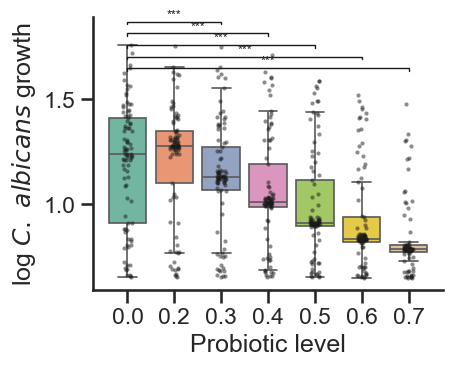

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import wilcoxon

d = tmp.loc[tmp['Cluster'] != 2].copy()
order = sorted(d['prob_lvl'].unique())

plt.figure(figsize=(5,4))
ax = plt.gca()

sns.boxplot(
    data=d, x='prob_lvl', y='log_growth',
    hue='prob_lvl', palette='Set2', order=order,
    legend=False, fliersize=0, linewidth=1.2, ax=ax
)
sns.stripplot(
    data=d, x='prob_lvl', y='log_growth', order=order,
    color='k', alpha=0.5, size=3, ax=ax
)

# ---------- FDR + stars ----------
def bh_fdr(pvals):
    pvals = np.asarray(pvals, float)
    m = len(pvals)
    o = np.argsort(pvals)
    r = pvals[o]
    adj = r * m / (np.arange(1, m+1))
    adj = np.minimum.accumulate(adj[::-1])[::-1]
    adj = np.clip(adj, 0, 1)
    out = np.empty_like(adj)
    out[o] = adj
    return out

def p_to_stars(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return None

ref = 0.0
if ref in order:
    # 关键：pivot 后自动按 sample 配对对齐
    wide = (d.pivot_table(index="sample", columns="prob_lvl", values="log_growth", aggfunc="mean")
              .sort_index())

    tests, pvals, nps = [], [], []
    for lvl in order:
        if lvl == ref:
            continue
        if (ref not in wide.columns) or (lvl not in wide.columns):
            continue

        m = wide[[ref, lvl]].dropna()
        n_pairs = len(m)
        if n_pairs < 2:
            continue

        diff = (m[lvl] - m[ref]).to_numpy()
        if np.allclose(diff, 0):
            p = 1.0
        else:
            p = float(wilcoxon(diff, alternative="two-sided",
                               zero_method="wilcox", method="auto").pvalue)

        tests.append(lvl)
        pvals.append(p)
        nps.append(n_pairs)

    if pvals:
        p_adj = bh_fdr(pvals)

        ymin, ymax = ax.get_ylim()
        yr = ymax - ymin
        pad  = 0.02 * yr
        step = 0.045 * yr
        h    = 0.01 * yr

        top = d.groupby('prob_lvl')['log_growth'].quantile(0.95).reindex(order).to_dict()

        x1 = order.index(ref)
        max_y_used = ymax
        level = 0
        for lvl, pa in sorted(zip(tests, p_adj), key=lambda t: t[1]):
            stars = p_to_stars(pa)
            if not stars:
                continue

            x2 = order.index(lvl)
            y = max(top[ref], top[lvl]) + pad + level * step

            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='k')
            ax.text((x1+x2)/2, y+h + 0.002*yr, stars,
                    ha='center', va='bottom', fontsize=9)

            max_y_used = max(max_y_used, y + h + 0.02*yr)
            level += 1

        ax.set_ylim(ymin, max_y_used)

ax.set_ylabel(r'log $C.\ albicans$ growth')
ax.set_xlabel('Probiotic level')
plt.tight_layout()
# plt.savefig('/Users/mengya/SDU/GSMM/mt_project/results_new/Cal-Probiotic-boxplots_Wilcoxon.pdf',bbox_inches='tight')
plt.show()

In [97]:
prob_strains = growth_rates_grouped_all[
    growth_rates_grouped_all['compartments']=='Lactobacillus_crispatus'
    ].reset_index(drop=True).copy()

prob_strains['prob_log_growth']=np.log10(prob_strains.growth_rate)
prob_strains.loc[prob_strains.index[prob_strains['prob_log_growth']<-6],'prob_log_growth']=-6
prob_strains.index=prob_strains['sample']
prob_strains = prob_strains.drop(columns=['sample', 'tradeoff'])
prob_strains = prob_strains.reset_index()
prob_strains

,sample,compartments,growth_rate,abundance,condition,cal_lvl,prob_lvl,group,prob_log_growth
0,H19,Lactobacillus_crispatus,40.549603,0.889870,0.1cal-invade,0.1,0.0,healthy,1.607987
1,C19,Lactobacillus_crispatus,0.012323,0.000066,0.1cal-invade,0.1,0.0,CVVC,-1.909289
2,H47,Lactobacillus_crispatus,0.012557,0.000076,0.1cal-invade,0.1,0.0,healthy,-1.901126
3,H43,Lactobacillus_crispatus,42.835512,0.813685,0.1cal-invade,0.1,0.0,healthy,1.631804
4,C21,Lactobacillus_crispatus,45.135404,0.232725,0.1cal-invade,0.1,0.0,CVVC,1.654517
...,...,...,...,...,...,...,...,...,...
853,V26,Lactobacillus_crispatus,41.813983,0.702501,0.1cal-0.7prob,0.1,0.7,AVVC+prob,1.621322
854,H47,Lactobacillus_crispatus,42.204283,0.705367,0.1cal-0.7prob,0.1,0.7,healthy+prob,1.625357
855,C21,Lactobacillus_crispatus,45.135404,0.786644,0.1cal-0.7prob,0.1,0.7,CVVC+prob,1.654517
856,C18,Lactobacillus_crispatus,45.135408,0.793255,0.1cal-0.7prob,0.1,0.7,CVVC+prob,1.654517


In [98]:
tmp0=cal_prob[cal_prob.condition != '0.1cal-invade'].copy()
tmp0.columns=['sample','cal_growth_rate','condition','cal_lvl','prob_lvl','group','cal_log_growth','Cluster']
tmp0=tmp0[['sample','condition','cal_log_growth','Cluster']].drop_duplicates()
tmp0

,sample,condition,cal_log_growth,Cluster
130,H17,0.1cal-0.2prob,1.309713,3
131,C11,0.1cal-0.2prob,1.246326,3
132,V15,0.1cal-0.2prob,1.244140,2
133,H28,0.1cal-0.2prob,0.660401,3
134,H7,0.1cal-0.2prob,0.675662,2
...,...,...,...,...
905,V26,0.1cal-0.7prob,0.776174,2
906,H47,0.1cal-0.7prob,0.780200,4
907,C21,0.1cal-0.7prob,0.864189,4
908,C18,0.1cal-0.7prob,1.062952,1


In [99]:
tmp1 = cal_prob[cal_prob.condition != '0.1cal-invade'].copy()
tmp2 = cal_prob[cal_prob.condition == '0.1cal-invade'].copy()

tmp1.set_index('sample', inplace=True)
tmp2.set_index('sample', inplace=True)

results = []

# 计算每个 condition 的比率和差值
for cond in tmp1['condition'].unique():
    df = tmp1[tmp1['condition'] == cond]
    for sample in df.index:  # 在每个条件下，遍历相关的样本
        if sample in tmp2.index:  # 确保该样本在 tmp2 中存在
            ratio = (10 ** df.loc[sample, 'log_growth']) / (10 ** tmp2.loc[sample, 'log_growth'])
            diff = (10 ** df.loc[sample, 'log_growth']) - (10 ** tmp2.loc[sample, 'log_growth'])

            # 存入结果
            results.append({
                'sample': sample,
                'condition': cond,
                'cal_growth_ratio': ratio,
                'cal_growth_diff': diff
            })

# 将结果列表转换为 DataFrame
results_df = pd.DataFrame(results)

# 根据样本和条件合并
tmp0 = tmp0.merge(results_df, on=['sample', 'condition'], how='left')
tmp0

,sample,condition,cal_log_growth,Cluster,cal_growth_ratio,cal_growth_diff
0,H17,0.1cal-0.2prob,1.309713,3,2.502822,12.251548
1,C11,0.1cal-0.2prob,1.246326,3,2.015404,8.883886
2,V15,0.1cal-0.2prob,1.244140,2,1.346528,4.515052
3,H28,0.1cal-0.2prob,0.660401,3,1.009335,0.042312
4,H7,0.1cal-0.2prob,0.675662,2,0.988276,-0.056216
...,...,...,...,...,...,...
775,V26,0.1cal-0.7prob,0.776174,2,0.749504,-1.996188
776,H47,0.1cal-0.7prob,0.780200,4,0.363178,-10.570581
777,C21,0.1cal-0.7prob,0.864189,4,0.301385,-16.955323
778,C18,0.1cal-0.7prob,1.062952,1,0.259924,-32.914143


In [100]:
# 过滤条件不等于 '0.1cal-invade' 的行
prob_tmp1 = prob_strains[prob_strains['condition'] != '0.1cal-invade'].copy()
prob_tmp2 = prob_strains[prob_strains['condition'] == '0.1cal-invade'].copy()

# 将样本列设置为索引
prob_tmp1.set_index('sample', inplace=True)
prob_tmp2.set_index('sample', inplace=True)

# 初始化结果列表
results = []

# 计算每个 condition 的比率和差值
for cond in prob_tmp1['condition'].unique():
    df = prob_tmp1[prob_tmp1['condition'] == cond]
    for sample in df.index:
        if sample in prob_tmp2.index:
            ratio = (10 ** df.loc[sample, 'prob_log_growth']) / (10 ** prob_tmp2.loc[sample, 'prob_log_growth'])
            diff = (10 ** df.loc[sample, 'prob_log_growth']) - (10 ** prob_tmp2.loc[sample, 'prob_log_growth'])
        else:
            # 假设缺失样本的 log_growth 默认值为 0
            default_log_growth = 0
            ratio = (10 ** df.loc[sample, 'prob_log_growth']) / (10 ** default_log_growth)
            diff = (10 ** df.loc[sample, 'prob_log_growth']) - (10 ** default_log_growth)

        # 存入结果
        results.append({
            'sample': sample,
            'condition': cond,
            'prob_growth_ratio': ratio,
            'prob_growth_diff': diff
        })

# 将结果列表转换为 DataFrame
results_df = pd.DataFrame(results)

# 使用 merge 而不是 join，根据样本和条件合并
prob_tmp0 = prob_strains[prob_strains['condition'] != '0.1cal-invade'].copy()
prob_tmp0 = prob_tmp0.merge(results_df, on=['sample', 'condition'], how='left')

# 返回 prob_tmp0
prob_tmp0

,sample,compartments,growth_rate,abundance,condition,cal_lvl,prob_lvl,group,prob_log_growth,prob_growth_ratio,prob_growth_diff
0,H17,Lactobacillus_crispatus,40.810468,0.309423,0.1cal-0.2prob,0.1,0.2,healthy+prob,1.610772,40.810468,3.981047e+01
1,C11,Lactobacillus_crispatus,35.286756,0.203916,0.1cal-0.2prob,0.1,0.2,CVVC+prob,1.547612,5708.403455,3.528057e+01
2,V15,Lactobacillus_crispatus,35.100515,0.200784,0.1cal-0.2prob,0.1,0.2,AVVC+prob,1.545313,35.100515,3.410051e+01
3,H28,Lactobacillus_crispatus,40.392888,0.893569,0.1cal-0.2prob,0.1,0.2,healthy+prob,1.606305,0.998050,-7.892083e-02
4,H7,Lactobacillus_crispatus,40.947614,0.870558,0.1cal-0.2prob,0.1,0.2,healthy+prob,1.612229,0.990089,-4.098979e-01
...,...,...,...,...,...,...,...,...,...,...,...
775,V26,Lactobacillus_crispatus,41.813983,0.702501,0.1cal-0.7prob,0.1,0.7,AVVC+prob,1.621322,41.813983,4.081398e+01
776,H47,Lactobacillus_crispatus,42.204283,0.705367,0.1cal-0.7prob,0.1,0.7,healthy+prob,1.625357,3361.106855,4.219173e+01
777,C21,Lactobacillus_crispatus,45.135404,0.786644,0.1cal-0.7prob,0.1,0.7,CVVC+prob,1.654517,1.000000,1.256470e-07
778,C18,Lactobacillus_crispatus,45.135408,0.793255,0.1cal-0.7prob,0.1,0.7,CVVC+prob,1.654517,25.498152,4.336526e+01


In [101]:
prob_strains2=pd.merge(prob_tmp0,tmp0,on=['sample','condition'])
prob_strains2

,sample,compartments,growth_rate,abundance,condition,cal_lvl,prob_lvl,group,prob_log_growth,prob_growth_ratio,prob_growth_diff,cal_log_growth,Cluster,cal_growth_ratio,cal_growth_diff
0,H17,Lactobacillus_crispatus,40.810468,0.309423,0.1cal-0.2prob,0.1,0.2,healthy+prob,1.610772,40.810468,3.981047e+01,1.309713,3,2.502822,12.251548
1,C11,Lactobacillus_crispatus,35.286756,0.203916,0.1cal-0.2prob,0.1,0.2,CVVC+prob,1.547612,5708.403455,3.528057e+01,1.246326,3,2.015404,8.883886
2,V15,Lactobacillus_crispatus,35.100515,0.200784,0.1cal-0.2prob,0.1,0.2,AVVC+prob,1.545313,35.100515,3.410051e+01,1.244140,2,1.346528,4.515052
3,H28,Lactobacillus_crispatus,40.392888,0.893569,0.1cal-0.2prob,0.1,0.2,healthy+prob,1.606305,0.998050,-7.892083e-02,0.660401,3,1.009335,0.042312
4,H7,Lactobacillus_crispatus,40.947614,0.870558,0.1cal-0.2prob,0.1,0.2,healthy+prob,1.612229,0.990089,-4.098979e-01,0.675662,2,0.988276,-0.056216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,V26,Lactobacillus_crispatus,41.813983,0.702501,0.1cal-0.7prob,0.1,0.7,AVVC+prob,1.621322,41.813983,4.081398e+01,0.776174,2,0.749504,-1.996188
776,H47,Lactobacillus_crispatus,42.204283,0.705367,0.1cal-0.7prob,0.1,0.7,healthy+prob,1.625357,3361.106855,4.219173e+01,0.780200,4,0.363178,-10.570581
777,C21,Lactobacillus_crispatus,45.135404,0.786644,0.1cal-0.7prob,0.1,0.7,CVVC+prob,1.654517,1.000000,1.256470e-07,0.864189,4,0.301385,-16.955323
778,C18,Lactobacillus_crispatus,45.135408,0.793255,0.1cal-0.7prob,0.1,0.7,CVVC+prob,1.654517,25.498152,4.336526e+01,1.062952,1,0.259924,-32.914143


In [102]:
data=prob_strains2.loc[~prob_strains2['group'].isin(['healthy+prob'])].copy()
data

,sample,compartments,growth_rate,abundance,condition,cal_lvl,prob_lvl,group,prob_log_growth,prob_growth_ratio,prob_growth_diff,cal_log_growth,Cluster,cal_growth_ratio,cal_growth_diff
1,C11,Lactobacillus_crispatus,35.286756,0.203916,0.1cal-0.2prob,0.1,0.2,CVVC+prob,1.547612,5708.403455,3.528057e+01,1.246326,3,2.015404,8.883886
2,V15,Lactobacillus_crispatus,35.100515,0.200784,0.1cal-0.2prob,0.1,0.2,AVVC+prob,1.545313,35.100515,3.410051e+01,1.244140,2,1.346528,4.515052
5,V6,Lactobacillus_crispatus,41.165016,0.201424,0.1cal-0.2prob,0.1,0.2,AVVC+prob,1.614528,41.165016,4.016502e+01,1.313997,4,0.897177,-2.361617
6,C2,Lactobacillus_crispatus,42.642333,0.339859,0.1cal-0.2prob,0.1,0.2,CVVC+prob,1.629841,1.036600,1.505603e+00,1.102755,4,0.548828,-10.415014
8,V35,Lactobacillus_crispatus,45.135404,0.390089,0.1cal-0.2prob,0.1,0.2,AVVC+prob,1.654517,1.000000,1.350195e-07,1.271930,4,0.619322,-11.496637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772,V22,Lactobacillus_crispatus,42.290894,0.702420,0.1cal-0.7prob,0.1,0.7,AVVC+prob,1.626247,42.290894,4.129089e+01,0.781101,3,0.421333,-8.296673
775,V26,Lactobacillus_crispatus,41.813983,0.702501,0.1cal-0.7prob,0.1,0.7,AVVC+prob,1.621322,41.813983,4.081398e+01,0.776174,2,0.749504,-1.996188
777,C21,Lactobacillus_crispatus,45.135404,0.786644,0.1cal-0.7prob,0.1,0.7,CVVC+prob,1.654517,1.000000,1.256470e-07,0.864189,4,0.301385,-16.955323
778,C18,Lactobacillus_crispatus,45.135408,0.793255,0.1cal-0.7prob,0.1,0.7,CVVC+prob,1.654517,25.498152,4.336526e+01,1.062952,1,0.259924,-32.914143


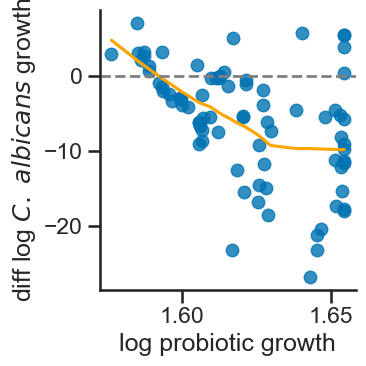

In [104]:
g = data.groupby('sample', as_index=False).agg(
    l1=('prob_log_growth', 'mean'),
    l2=('cal_growth_diff', 'mean')
)

x = g['l1'].to_numpy()
y = g['l2'].to_numpy()

mask = np.isfinite(x) & np.isfinite(y) & (y < 10)

fit = sm.nonparametric.lowess(y[mask], x[mask], frac=0.6)

# 创建图形
plt.figure(figsize=(4, 4))
sns.regplot(x=x[mask], y=y[mask], fit_reg=False)

# 绘制 LOWESS 拟合线（使用橙色）
plt.plot(fit[:, 0], fit[:, 1], color='#FFA500')  # 橙色的 hex 代码

# 添加纵坐标 0 的灰色虚线
plt.axhline(y=0, color='gray', linestyle='--', linewidth=2)

# 设置标签
plt.xlabel('log probiotic growth')
plt.ylabel(r'diff log $C.\ albicans$ growth')

# 美化布局
plt.tight_layout()
# 保存
# plt.savefig('/Users/mengya/SDU/GSMM/mt_project/results_new/cal_diff_growth-vs-probiotic_growth.pdf',bbox_inches='tight')
# 显示图形
plt.show()

## Probiotics 3

In [111]:
# 读取所有匹配模式的文件
prob_ratios = [round(x, 1) for x in [i/10 for i in range(2, 8)]] 
file_pattern2 = '/Users/mengya/SDU/GSMM/mt_project/results_new/final_prob*-treat1_fluxes_tradeoff0.8_pfba-new.pkl'
files = sorted(glob.glob(file_pattern2))

# 读取并合并所有文件
fluxes_prob_all = pd.concat([pd.read_pickle(f).reset_index() for f in files], ignore_index=True)
fluxes_prob_all

reaction,compartment,12DGR180ti,12PPDSDH,12PPD_Stex,12PPDt,12PPDtpp,13PPDH,13PPDt,13PPDtex,13PPDtpp,...,MPPP9MMEOR3,MPPP9MT,NMPTRCOX,PEAMNO,biomass474,biomass479,biomass489,biomass512,biomass444,biomass448
0,Aerococcus_christensenii,0.014840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aspergillus_oryzae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bacillus_cereus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bacillus_velezensis,0.000531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Botrytis_cinerea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26051,Stenotrophomonas_maltophilia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26052,Streptococcus_pyogenes,0.000770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26053,Yersinia_enterocolitica,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26054,_Ruminococcus_torques,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
prob_fluxes = fluxes_prob_all.set_index('compartment')
prob_fluxes

reaction,12DGR180ti,12PPDSDH,12PPD_Stex,12PPDt,12PPDtpp,13PPDH,13PPDt,13PPDtex,13PPDtpp,15DAPt,...,MPPP9MMEOR3,MPPP9MT,NMPTRCOX,PEAMNO,biomass474,biomass479,biomass489,biomass512,biomass444,biomass448
compartment,,,,,,,,,,,,,,,,,,,,,
Aerococcus_christensenii,0.014840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aspergillus_oryzae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bacillus_cereus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bacillus_velezensis,0.000531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Botrytis_cinerea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Stenotrophomonas_maltophilia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Streptococcus_pyogenes,0.000770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yersinia_enterocolitica,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
prob_fluxes['condition'].drop_duplicates()

compartment
Aerococcus_christensenii    0.1cal-0.2prob
Aspergillus_oryzae          0.1cal-0.3prob
Aspergillus_oryzae          0.1cal-0.4prob
Aspergillus_oryzae          0.1cal-0.5prob
Aerococcus_christensenii    0.1cal-0.6prob
Aspergillus_oryzae          0.1cal-0.7prob
Name: condition, dtype: object

In [114]:
prob_growth_all = growth_rates_prob_all.copy()
prob_growth_all.index=pd.MultiIndex.from_tuples([(growth_rates_prob_all.loc[i,'sample'],prob_growth_all.loc[i,'compartments']) for i in growth_rates_prob_all.index])
prob_growth_all=prob_growth_all.drop(['compartments','sample'],axis=1)
prob_growth_all['log_growth']=np.log10(prob_growth_all.growth_rate)
idx=prob_growth_all.index[prob_growth_all['log_growth']<-6]
prob_growth_all.loc[idx,'log_growth']=-6
prob_growth_all

growth_rate  abundance       condition  \
H17 Aerococcus_christensenii         0.356901   0.002706  0.1cal-0.2prob   
    Aspergillus_oryzae               0.070903   0.000538  0.1cal-0.2prob   
    Bacillus_cereus                  0.012803   0.000097  0.1cal-0.2prob   
    Bacillus_velezensis              0.012510   0.000095  0.1cal-0.2prob   
    Botrytis_cinerea                 0.031289   0.000237  0.1cal-0.2prob   
...                                       ...        ...             ...   
C24 Stenotrophomonas_maltophilia     0.229934   0.004275  0.1cal-0.7prob   
    Streptococcus_pyogenes           0.019068   0.000355  0.1cal-0.7prob   
    Yersinia_enterocolitica          0.048255   0.000897  0.1cal-0.7prob   
    _Ruminococcus_torques            0.003138   0.000059  0.1cal-0.7prob   
    community                       35.861774   1.000000  0.1cal-0.7prob   

                                  tradeoff  cal_lvl  prob_lvl  log_growth  
H17 Aerococcus_christensenii           0.8      0.1       0.2   -0.447453  
    Aspergillus_oryzae                 0.8      0.1       0.2   -1.149338  
    Bacillus_cereus                    0.8      0.1       0.2   -1.892682  
    Bacillus_velezensis                0.8      0.1       0.2   -1.902751  
    Botrytis_cinerea                   0.8      0.1       0.2   -1.504603  
...                                    ...      ...       ...         ...  
C24 Stenotrophomonas_maltophilia       0.8      0.1       0.7   -0.638397  
    Streptococcus_pyogenes             0.8      0.1       0.7   -1.719692  
    Yersinia_enterocolitica            0.8      0.1       0.7   -1.316456  
    _Ruminococcus_torques              0.8      0.1       0.7   -2.503332  
    community                          0.8      0.1       0.7    1.554632  

[26056 rows x 7 columns]

In [115]:
strain_fluxes = prob_fluxes.copy()

# 创建 MultiIndex，添加 condition 列
strain_fluxes.index = pd.MultiIndex.from_tuples([
    (strain_fluxes.iloc[i, :]['sample'], strain_fluxes.iloc[i, :]['condition'], strain_fluxes.index[i])
    for i in range(len(strain_fluxes.index))
])

# 填充缺失值并删除 sample 列
strain_fluxes = strain_fluxes.fillna(10 ** -6).drop(['sample'], axis=1)

# 筛选出交换反应
strain_exchanges = strain_fluxes.filter(regex=r'^EX_|_E$')

# 筛选输出
strain_export = strain_exchanges.copy()[[x[2] != 'community' and x[2] != 'medium' for x in strain_exchanges.index]]
strain_export[strain_export <= 0] = 10 ** -6
strain_export = np.log10(strain_export).fillna(-6)

# 筛选输入
strain_import = strain_exchanges.copy()[[x[2] != 'community' and x[2] != 'medium' for x in strain_exchanges.index]]
strain_import[strain_import >= 0] = 10 ** -6
strain_import = abs(strain_import)
strain_import = np.log10(strain_import).fillna(-6)

# 只保留有效数据
strain_import = strain_import[strain_import > -6].fillna(-6)
strain_export = strain_export[strain_export > -6].fillna(-6)

strain_import

reaction                                         EX_10Ehpda_m  EX_10Zhpda_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii              -6.0          -6.0   
                   Aspergillus_oryzae                    -6.0          -6.0   
                   Bacillus_cereus                       -6.0          -6.0   
                   Bacillus_velezensis                   -6.0          -6.0   
                   Botrytis_cinerea                      -6.0          -6.0   
...                                                       ...           ...   
C24 0.1cal-0.7prob Staphylococcus_nepalensis             -6.0          -6.0   
                   Stenotrophomonas_maltophilia          -6.0          -6.0   
                   Streptococcus_pyogenes                -6.0          -6.0   
                   Yersinia_enterocolitica               -6.0          -6.0   
                   _Ruminococcus_torques                 -6.0          -6.0   

reaction                                         EX_124bztriol_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii                 -6.0   
                   Aspergillus_oryzae                       -6.0   
                   Bacillus_cereus                          -6.0   
                   Bacillus_velezensis                      -6.0   
                   Botrytis_cinerea                         -6.0   
...                                                          ...   
C24 0.1cal-0.7prob Staphylococcus_nepalensis                -6.0   
                   Stenotrophomonas_maltophilia             -6.0   
                   Streptococcus_pyogenes                   -6.0   
                   Yersinia_enterocolitica                  -6.0   
                   _Ruminococcus_torques                    -6.0   

reaction                                         EX_12dgr180(e)  \
H17 0.1cal-0.2prob Aerococcus_christensenii           -1.828584   
                   Aspergillus_oryzae                 -6.000000   
                   Bacillus_cereus                    -6.000000   
                   Bacillus_velezensis                -3.275093   
                   Botrytis_cinerea                   -6.000000   
...                                                         ...   
C24 0.1cal-0.7prob Staphylococcus_nepalensis          -6.000000   
                   Stenotrophomonas_maltophilia       -6.000000   
                   Streptococcus_pyogenes             -3.113632   
                   Yersinia_enterocolitica            -6.000000   
                   _Ruminococcus_torques              -6.000000   

reaction                                         EX_12dgr180_m  EX_12ethd_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii               -6.0         -6.0   
                   Aspergillus_oryzae                     -6.0         -6.0   
                   Bacillus_cereus                        -6.0         -6.0   
                   Bacillus_velezensis                    -6.0         -6.0   
                   Botrytis_cinerea                       -6.0         -6.0   
...                                                        ...          ...   
C24 0.1cal-0.7prob Staphylococcus_nepalensis              -6.0         -6.0   
                   Stenotrophomonas_maltophilia           -6.0         -6.0   
                   Streptococcus_pyogenes                 -6.0         -6.0   
                   Yersinia_enterocolitica                -6.0         -6.0   
                   _Ruminococcus_torques                  -6.0         -6.0   

reaction                                         EX_12ppd_S(e)  EX_12ppd_S_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii               -6.0          -6.0   
                   Aspergillus_oryzae                     -6.0          -6.0   
                   Bacillus_cereus                        -6.0          -6.0   
                   Bacillus_velezensis                    -6.0          -6.0   
                   Botrytis_cinerea                       -6.0          -6.0   


In [116]:
smps = cal_prob[~cal_prob['condition'].isin(['0.1cal-invade'])].copy()
smps = smps[smps['log_growth'] >= -6]
smps = smps['sample'].unique()
smps

array(['H17', 'C11', 'V15', 'H28', 'H7', 'V6', 'C2', 'H4', 'V35', 'V2',
       'H33', 'V11', 'V29', 'C8', 'H14', 'V31', 'V39', 'V1', 'V48', 'H26',
       'H21', 'H12', 'H44', 'V24', 'C13', 'H45', 'H41', 'V10', 'H27',
       'V20', 'C26', 'H37', 'V14', 'C29', 'H5', 'V7', 'H32', 'V34', 'C3',
       'H11', 'V28', 'H13', 'V3', 'C9', 'H22', 'C19', 'C17', 'C16', 'V42',
       'C12', 'H1', 'H46', 'C30', 'H40', 'V49', 'H20', 'V38', 'V23',
       'H48', 'H25', 'V30', 'H31', 'C25', 'V19', 'V4', 'V33', 'H36', 'C4',
       'C6', 'C23', 'H10', 'V8', 'H2', 'H16', 'V17', 'C15', 'H29', 'H19',
       'V27', 'V18', 'H43', 'V46', 'H8', 'V36', 'H24', 'V26', 'H38',
       'C27', 'V22', 'V44', 'H49', 'V43', 'H30', 'H47', 'C1', 'V41',
       'C21', 'C7', 'V5', 'V12', 'C24', 'H15', 'C10', 'C18', 'H34', 'V13',
       'H6', 'H9', 'V32', 'C14', 'V37', 'H42', 'V47', 'V25', 'V9', 'H35',
       'V45', 'V16', 'C28', 'H3', 'H18', 'V40', 'H23', 'C5', 'H50', 'H39',
       'C22', 'V21', 'C20', 'V50'], dtype=object)

In [117]:
smp_import = strain_import.loc[smps]
smp_import

reaction                                     EX_10Ehpda_m  EX_10Zhpda_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii          -6.0          -6.0   
                   Aspergillus_oryzae                -6.0          -6.0   
                   Bacillus_cereus                   -6.0          -6.0   
                   Bacillus_velezensis               -6.0          -6.0   
                   Botrytis_cinerea                  -6.0          -6.0   
...                                                   ...           ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii            -6.0          -6.0   
                   Lactobacillus_johnsonii           -6.0          -6.0   
                   Staphylococcus_aureus             -6.0          -6.0   
                   Talaromyces_marneffei             -6.0          -6.0   
                   Yersinia_enterocolitica           -6.0          -6.0   

reaction                                     EX_124bztriol_m  EX_12dgr180(e)  \
H17 0.1cal-0.2prob Aerococcus_christensenii             -6.0       -1.828584   
                   Aspergillus_oryzae                   -6.0       -6.000000   
                   Bacillus_cereus                      -6.0       -6.000000   
                   Bacillus_velezensis                  -6.0       -3.275093   
                   Botrytis_cinerea                     -6.0       -6.000000   
...                                                      ...             ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii               -6.0       -6.000000   
                   Lactobacillus_johnsonii              -6.0       -3.505638   
                   Staphylococcus_aureus                -6.0       -2.987828   
                   Talaromyces_marneffei                -6.0       -6.000000   
                   Yersinia_enterocolitica              -6.0       -6.000000   

reaction                                     EX_12dgr180_m  EX_12ethd_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii           -6.0         -6.0   
                   Aspergillus_oryzae                 -6.0         -6.0   
                   Bacillus_cereus                    -6.0         -6.0   
                   Bacillus_velezensis                -6.0         -6.0   
                   Botrytis_cinerea                   -6.0         -6.0   
...                                                    ...          ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii             -6.0         -6.0   
                   Lactobacillus_johnsonii            -6.0         -6.0   
                   Staphylococcus_aureus              -6.0         -6.0   
                   Talaromyces_marneffei              -6.0         -6.0   
                   Yersinia_enterocolitica            -6.0         -6.0   

reaction                                     EX_12ppd_S(e)  EX_12ppd_S_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii           -6.0          -6.0   
                   Aspergillus_oryzae                 -6.0          -6.0   
                   Bacillus_cereus                    -6.0          -6.0   
                   Bacillus_velezensis                -6.0          -6.0   
                   Botrytis_cinerea                   -6.0          -6.0   
...                                                    ...           ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii             -6.0          -6.0   
                   Lactobacillus_johnsonii            -6.0          -6.0   
                   Staphylococcus_aureus              -6.0          -6.0   
                   Talaromyces_marneffei              -6.0          -6.0   
                   Yersinia_enterocolitica            -6.0          -6.0   

reaction                                     EX_13BDglcn_m  EX_13ppd(e)  ...  \
H17 0.1cal-0.2prob Aerococcus_christensenii           -6.0         -6.0  ...   
                   Aspergillus_oryzae                 -6.0         -6.0  ...   
                   Bacillus_cereus                    -6.0         -6.0  ...   
    

In [118]:
smp_growth = prob_growth_all.copy()
smp_growth = smp_growth.loc[smps]

# 先添加 condition 为索引
smp_growth = smp_growth.set_index("condition", append=True)

# 把 condition 调到第二层索引
levels = list(smp_growth.index.names)
cond_i = levels.index("condition")
new_order = [0, cond_i] + [i for i in range(len(levels)) if i not in (0, cond_i)]
smp_growth = smp_growth.reorder_levels(new_order).sort_index()
# 去掉所有层的索引名
smp_growth.index = smp_growth.index.set_names([None] * smp_growth.index.nlevels)
smp_growth

growth_rate  abundance  tradeoff  \
C1 0.1cal-0.2prob Aerococcus_christensenii      0.010593   0.000097       0.8   
                  Anaerococcus_vaginalis        0.005515   0.000056       0.8   
                  Aspergillus_oryzae            0.085086   0.001041       0.8   
                  Botrytis_cinerea              0.026348   0.000322       0.8   
                  Campylobacter_ureolyticus     0.007981   0.000098       0.8   
...                                                  ...        ...       ...   
V9 0.1cal-0.7prob Staphylococcus_aureus         0.011057   0.000180       0.8   
                  Streptococcus_pneumoniae      0.004983   0.000081       0.8   
                  Talaromyces_marneffei         0.006836   0.000111       0.8   
                  Yersinia_enterocolitica       0.005601   0.000091       0.8   
                  community                    32.697439   1.000000       0.8   

                                             cal_lvl  prob_lvl  log_growth  
C1 0.1cal-0.2prob Aerococcus_christensenii       0.1       0.2   -1.975000  
                  Anaerococcus_vaginalis         0.1       0.2   -2.258429  
                  Aspergillus_oryzae             0.1       0.2   -1.070142  
                  Botrytis_cinerea               0.1       0.2   -1.579257  
                  Campylobacter_ureolyticus      0.1       0.2   -2.097953  
...                                              ...       ...         ...  
V9 0.1cal-0.7prob Staphylococcus_aureus          0.1       0.7   -1.956375  
                  Streptococcus_pneumoniae       0.1       0.7   -2.302520  
                  Talaromyces_marneffei          0.1       0.7   -2.165204  
                  Yersinia_enterocolitica        0.1       0.7   -2.251769  
                  community                      0.1       0.7    1.514514  

[26056 rows x 6 columns]

In [119]:
clr_import_row=pd.DataFrame(index=smp_import.index,columns=smp_import.columns)
for row in smp_import.index:
    clr_import_row.loc[row,:]=composition.clr(10**smp_import.loc[row,:])
clr_import_row

reaction                                    EX_10Ehpda_m EX_10Zhpda_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii    -0.250548    -0.250548   
                   Aspergillus_oryzae          -0.190449    -0.190449   
                   Bacillus_cereus             -0.197083    -0.197083   
                   Bacillus_velezensis         -0.145253    -0.145253   
                   Botrytis_cinerea            -0.166308    -0.166308   
...                                                  ...          ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii        -0.2152      -0.2152   
                   Lactobacillus_johnsonii     -0.119734    -0.119734   
                   Staphylococcus_aureus       -0.150494    -0.150494   
                   Talaromyces_marneffei       -0.104344    -0.104344   
                   Yersinia_enterocolitica     -0.221665    -0.221665   

reaction                                    EX_124bztriol_m EX_12dgr180(e)  \
H17 0.1cal-0.2prob Aerococcus_christensenii       -0.250548       9.354494   
                   Aspergillus_oryzae             -0.190449      -0.190449   
                   Bacillus_cereus                -0.197083      -0.197083   
                   Bacillus_velezensis            -0.145253       6.129078   
                   Botrytis_cinerea               -0.166308      -0.166308   
...                                                     ...            ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii           -0.2152        -0.2152   
                   Lactobacillus_johnsonii        -0.119734       5.623746   
                   Staphylococcus_aureus          -0.150494       6.785289   
                   Talaromyces_marneffei          -0.104344      -0.104344   
                   Yersinia_enterocolitica        -0.221665      -0.221665   

reaction                                    EX_12dgr180_m EX_12ethd_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii     -0.250548   -0.250548   
                   Aspergillus_oryzae           -0.190449   -0.190449   
                   Bacillus_cereus              -0.197083   -0.197083   
                   Bacillus_velezensis          -0.145253   -0.145253   
                   Botrytis_cinerea             -0.166308   -0.166308   
...                                                   ...         ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii         -0.2152     -0.2152   
                   Lactobacillus_johnsonii      -0.119734   -0.119734   
                   Staphylococcus_aureus        -0.150494   -0.150494   
                   Talaromyces_marneffei        -0.104344   -0.104344   
                   Yersinia_enterocolitica      -0.221665   -0.221665   

reaction                                    EX_12ppd_S(e) EX_12ppd_S_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii     -0.250548    -0.250548   
                   Aspergillus_oryzae           -0.190449    -0.190449   
                   Bacillus_cereus              -0.197083    -0.197083   
                   Bacillus_velezensis          -0.145253    -0.145253   
                   Botrytis_cinerea             -0.166308    -0.166308   
...                                                   ...          ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii         -0.2152      -0.2152   
                   Lactobacillus_johnsonii      -0.119734    -0.119734   
                   Staphylococcus_aureus        -0.150494    -0.150494   
                   Talaromyces_marneffei        -0.104344    -0.104344   
                   Yersinia_enterocolitica      -0.221665    -0.221665   

reaction                                    EX_13BDglcn_m EX_13ppd(e)  ...  \
H17 0.1cal-0.2prob Aerococcus_christensenii     -0.250548   -0.250548  ...   
                   Aspergillus_oryzae           -0.190449   -0.190449  ...   
                   Bacillus_cereus              -0.197083   -0.197083  ...   
                   Bacillus_velezensis          -0.145253   -0.145253  ...   
                   Botrytis_ci

In [122]:
clr_import_col=pd.DataFrame(index=smp_import.index,columns=smp_import.columns)
for col in smp_import.columns:
    clr_import_col[col]=composition.clr(10**smp_import[col])
clr_import_col

reaction                                     EX_10Ehpda_m  EX_10Zhpda_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii           0.0           0.0   
                   Aspergillus_oryzae                 0.0           0.0   
                   Bacillus_cereus                    0.0           0.0   
                   Bacillus_velezensis                0.0           0.0   
                   Botrytis_cinerea                   0.0           0.0   
...                                                   ...           ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii             0.0           0.0   
                   Lactobacillus_johnsonii            0.0           0.0   
                   Staphylococcus_aureus              0.0           0.0   
                   Talaromyces_marneffei              0.0           0.0   
                   Yersinia_enterocolitica            0.0           0.0   

reaction                                     EX_124bztriol_m  EX_12dgr180(e)  \
H17 0.1cal-0.2prob Aerococcus_christensenii              0.0        7.299543   
                   Aspergillus_oryzae                    0.0       -2.305499   
                   Bacillus_cereus                       0.0       -2.305499   
                   Bacillus_velezensis                   0.0        3.968833   
                   Botrytis_cinerea                      0.0       -2.305499   
...                                                      ...             ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii                0.0       -2.305499   
                   Lactobacillus_johnsonii               0.0        3.437981   
                   Staphylococcus_aureus                 0.0        4.630284   
                   Talaromyces_marneffei                 0.0       -2.305499   
                   Yersinia_enterocolitica               0.0       -2.305499   

reaction                                     EX_12dgr180_m  EX_12ethd_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii            0.0          0.0   
                   Aspergillus_oryzae                  0.0          0.0   
                   Bacillus_cereus                     0.0          0.0   
                   Bacillus_velezensis                 0.0          0.0   
                   Botrytis_cinerea                    0.0          0.0   
...                                                    ...          ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii              0.0          0.0   
                   Lactobacillus_johnsonii             0.0          0.0   
                   Staphylococcus_aureus               0.0          0.0   
                   Talaromyces_marneffei               0.0          0.0   
                   Yersinia_enterocolitica             0.0          0.0   

reaction                                     EX_12ppd_S(e)  EX_12ppd_S_m  \
H17 0.1cal-0.2prob Aerococcus_christensenii        -0.2082           0.0   
                   Aspergillus_oryzae              -0.2082           0.0   
                   Bacillus_cereus                 -0.2082           0.0   
                   Bacillus_velezensis             -0.2082           0.0   
                   Botrytis_cinerea                -0.2082           0.0   
...                                                    ...           ...   
V50 0.1cal-0.7prob Lactobacillus_jensenii          -0.2082           0.0   
                   Lactobacillus_johnsonii         -0.2082           0.0   
                   Staphylococcus_aureus           -0.2082           0.0   
                   Talaromyces_marneffei           -0.2082           0.0   
                   Yersinia_enterocolitica         -0.2082           0.0   

reaction                                     EX_13BDglcn_m  EX_13ppd(e)  ...  \
H17 0.1cal-0.2prob Aerococcus_christensenii            0.0          0.0  ...   
                   Aspergillus_oryzae                  0.0          0.0  ...   
                   Bacillus_cereus                     0.0          0.0  ...   
    

In [123]:
dist1 = []

for (s, c), d in smp_import.loc[smps].groupby(level=[0, 1]):
    ref = d.loc[(s, c, "Candida_albicans")]

    tmp = d.apply(lambda row: distance.euclidean(ref, row), axis=1)
    dist1.append(tmp.to_frame("euc-dist"))

dist1 = pd.concat(dist1).reset_index()
dist1.columns = ["sample", "condition", "species", "euc-dist"]
dist1

,sample,condition,species,euc-dist
0,C1,0.1cal-0.2prob,Aerococcus_christensenii,43.210439
1,C1,0.1cal-0.2prob,Anaerococcus_vaginalis,41.768436
2,C1,0.1cal-0.2prob,Aspergillus_oryzae,26.659675
3,C1,0.1cal-0.2prob,Botrytis_cinerea,29.848330
4,C1,0.1cal-0.2prob,Campylobacter_ureolyticus,42.461596
...,...,...,...,...
25271,V9,0.1cal-0.7prob,Pseudomonas_aeruginosa,45.843449
25272,V9,0.1cal-0.7prob,Staphylococcus_aureus,43.331500
25273,V9,0.1cal-0.7prob,Streptococcus_pneumoniae,42.302094
25274,V9,0.1cal-0.7prob,Talaromyces_marneffei,32.691843


In [124]:
dist2 = []

for (s, c), d in clr_import_row.loc[smps].groupby(level=[0, 1]):
    ref = d.loc[(s, c, "Candida_albicans")]

    tmp = d.apply(lambda row: distance.euclidean(ref, row), axis=1)
    dist2.append(tmp.to_frame("euc-dist"))

dist2 = pd.concat(dist2).reset_index()
dist2.columns = ["sample", "condition", "species", "euc-dist"]
dist2

,sample,condition,species,euc-dist
0,C1,0.1cal-0.2prob,Aerococcus_christensenii,99.350553
1,C1,0.1cal-0.2prob,Anaerococcus_vaginalis,95.965840
2,C1,0.1cal-0.2prob,Aspergillus_oryzae,61.212706
3,C1,0.1cal-0.2prob,Botrytis_cinerea,68.483087
4,C1,0.1cal-0.2prob,Campylobacter_ureolyticus,97.576042
...,...,...,...,...
25271,V9,0.1cal-0.7prob,Pseudomonas_aeruginosa,105.474705
25272,V9,0.1cal-0.7prob,Staphylococcus_aureus,99.563757
25273,V9,0.1cal-0.7prob,Streptococcus_pneumoniae,97.116067
25274,V9,0.1cal-0.7prob,Talaromyces_marneffei,74.867612


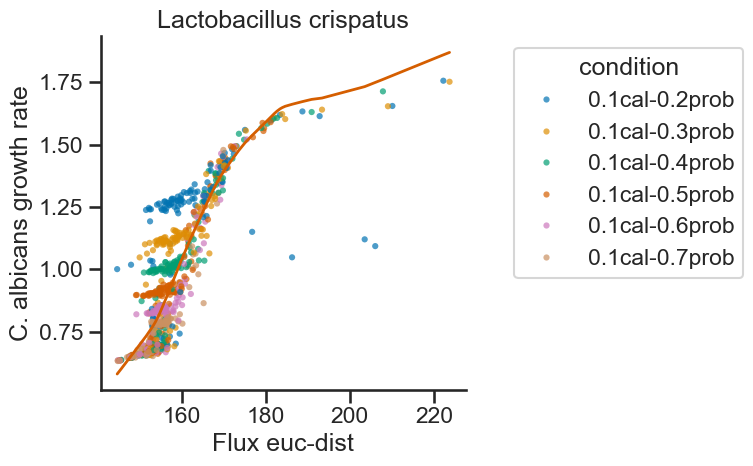

In [125]:
species = "Lactobacillus_crispatus"

# 1) 只取 Candida_albicans 的 log_growth，并把 sample、condition 从 MultiIndex 拆出来
idx = [i for i in smp_growth.index if "Candida_albicans" in i[2]]
tmp_growth = smp_growth.loc[idx].copy().reset_index()
tmp_growth = tmp_growth.rename(columns={"level_0": "sample", "level_1": "condition"})
tmp_growth = tmp_growth[["sample", "condition", "log_growth"]]

# 2) dist：取该物种的 sample、condition、euc-dist
tmp_dist = dist2.loc[dist2["species"] == species, ["sample", "condition", "euc-dist"]].copy()

# 3) 严格用 sample+condition 对齐
df = tmp_growth.merge(tmp_dist, on=["sample", "condition"], how="inner")

# 如果仍然有重复（同一个 sample+condition 多条），明确聚合规则（推荐取均值）
df = df.groupby(["sample", "condition"], as_index=False).agg(
    log_growth=("log_growth", "mean"),
    euc_dist=("euc-dist", "mean")
)

x = df["euc_dist"]
y = df["log_growth"]

fit = sm.nonparametric.lowess(y, x)

fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df, x="euc_dist", y="log_growth", hue="condition",
                s=20, alpha=0.7, linewidth=0, ax=ax)
ax.plot(fit[:, 0], fit[:, 1], color="r", linewidth=2)
ax.set_title("Lactobacillus crispatus")
ax.set_ylabel("C. albicans growth rate")
ax.set_xlabel("Flux euc-dist")
ax.legend(title="condition", bbox_to_anchor=(1.1, 1), loc="upper left")
plt.tight_layout()
# 保存
# plt.savefig('/Users/mengya/SDU/GSMM/mt_project/results_new/cal-probiotic_Flux_euc-dist_grouped.pdf',bbox_inches='tight')
plt.show()

## others

In [551]:
import pickle
import pandas as pd
from micom import load_pickle

In [553]:
model = load_pickle(r'D:\fsdownload\agora2_C1_invaded.pickle')
model

Name,C1
Memory address,0x025837e0a430
Number of metabolites,42386
Number of reactions,49542
Number of groups,0
Objective expression,1.0*community_objective
Compartments,"c__Bacillus_cereus, e__Bacillus_cereus, m, c__Staphylococcus_aureus, e__Staphylococcus_aureus, c__Lactiplantibacillus_plantarum, e__Lactiplantibacillus_plantarum, c__Lactobacillus_amylovorus, e__Lactobacillus_amylovorus, c__Lactobacillus_crispatus, e__Lactobacillus_crispatus, e__Lactobacillus_gasseri, c__Lactobacillus_gasseri, c__Lactobacillus_helveticus, e__Lactobacillus_helveticus, c__Lactobacillus_jensenii, e__Lactobacillus_jensenii, e__Lactobacillus_johnsonii, c__Lactobacillus_johnsonii, c__Limosilactobacillus_fermentum, e__Limosilactobacillus_fermentum, e__Limosilactobacillus_reuteri, c__Limosilactobacillus_reuteri, c__Limosilactobacillus_vaginalis, e__Limosilactobacillus_vaginalis, e__Escherichia_coli, p__Escherichia_coli, c__Escherichia_coli, c__Yersinia_enterocolitica, e__Yersinia_enterocolitica, p__Yersinia_enterocolitica, c__Acinetobacter_guillouiae, e__Acinetobacter_guillouiae, p__Acinetobacter_guillouiae, c__Acinetobacter_johnsonii, e__Acinetobacter_johnsonii, p__Acinetobacter_johnsonii, e__Pseudomonas_aeruginosa, p__Pseudomonas_aeruginosa, c__Pseudomonas_aeruginosa, c__Bacillus_mycoides, e__Bacillus_mycoides, e__Aerococcus_christensenii, c__Aerococcus_christensenii, e__Lactobacillus_iners, c__Lactobacillus_iners, c__Acinetobacter_baumannii, p__Acinetobacter_baumannii, e__Acinetobacter_baumannii, e__Bacillus_thuringiensis, c__Bacillus_thuringiensis, e__Herbaspirillum_huttiense, p__Herbaspirillum_huttiense, c__Herbaspirillum_huttiense, e__Stenotrophomonas_maltophilia, p__Stenotrophomonas_maltophilia, c__Stenotrophomonas_maltophilia, c__Faecalibacterium_prausnitzii, e__Faecalibacterium_prausnitzii, e__Limosilactobacillus_frumenti, c__Limosilactobacillus_frumenti, e__Limosilactobacillus_oris, c__Limosilactobacillus_oris, c__Aspergillus_oryzae, m__Aspergillus_oryzae, r__Aspergillus_oryzae, x__Aspergillus_oryzae, l__Aspergillus_oryzae, e__Aspergillus_oryzae, n__Aspergillus_oryzae, g__Aspergillus_oryzae, c__Botrytis_cinerea, m__Botrytis_cinerea, r__Botrytis_cinerea, x__Botrytis_cinerea, l__Botrytis_cinerea, e__Botrytis_cinerea, n__Botrytis_cinerea, g__Botrytis_cinerea, c__Candida_albicans, m__Candida_albicans, r__Candida_albicans, x__Candida_albicans, l__Candida_albicans, e__Candida_albicans, n__Candida_albicans, g__Candida_albicans"


In [585]:
model.exchanges

[<Reaction EX_26dap_M_m at 0x25898fb27f0>,
 <Reaction EX_2hyoxplac_m at 0x25898fb2820>,
 <Reaction EX_2obut_m at 0x25898fb2850>,
 <Reaction EX_34dhpha_m at 0x25898fb2880>,
 <Reaction EX_3hphac_m at 0x25898fb28b0>,
 <Reaction EX_4abut_m at 0x25898fb28e0>,
 <Reaction EX_4abz_m at 0x25898fb2910>,
 <Reaction EX_5asa_m at 0x25898fb2940>,
 <Reaction EX_5fura_m at 0x25898fb2970>,
 <Reaction EX_7a_czp_m at 0x25898fb29a0>,
 <Reaction EX_Lcyst_m at 0x25898fb29d0>,
 <Reaction EX_Tyr_ggn_m at 0x25898fb2a00>,
 <Reaction EX_ac_m at 0x25898fb2a30>,
 <Reaction EX_ac5asa_m at 0x25898fb2a60>,
 <Reaction EX_acac_m at 0x25898fb2a90>,
 <Reaction EX_acald_m at 0x25898fb2ac0>,
 <Reaction EX_acgam_m at 0x25898fb2af0>,
 <Reaction EX_acisnzd_m at 0x25898fb2b20>,
 <Reaction EX_actn_R_m at 0x25898fb2b50>,
 <Reaction EX_adn_m at 0x25898fb2b80>,
 <Reaction EX_ala_D_m at 0x25898fb2bb0>,
 <Reaction EX_ala_L_m at 0x25898fb2be0>,
 <Reaction EX_alaasp_m at 0x25898fb2c10>,
 <Reaction EX_alagln_m at 0x25898fb2c40>,
 <Reac

In [691]:
with open(r'D:\fsdownload\agora2_C1_invaded.pickle', 'rb') as f:
    community = pickle.load(f)

# 提取所有反应信息
reactions_data = []
for rxn in community.reactions:
    reactions_data.append({
        'ID': rxn.id,
        'name': rxn.name,
        'reaction': rxn.reaction,
        'lower_bound': rxn.lower_bound,
        'upper_bound': rxn.upper_bound
    })

exchanges_data = []
for rxn in community.exchanges:
    exchanges_data.append({
        'ID': rxn.id,
        'name': rxn.name,
        'reaction': rxn.reaction,
        'lower_bound': rxn.lower_bound,
        'upper_bound': rxn.upper_bound
    })

# 转换为 DataFrame
df = pd.DataFrame(reactions_data)
df2 = pd.DataFrame(exchanges_data)
# 导出为 CSV
df.to_csv(r'D:\MY\GSMM\mt_project\reactions.csv', index=False, encoding='utf-8')
df2.to_csv(r'D:\MY\GSMM\mt_project\exchanges.csv', index=False, encoding='utf-8')
print(f"共导出 {len(df)} 个反应,{len(df2)} 个交换反应 ")

共导出 49542 个反应,595 个交换反应 
